# Gradient Boosting 

 - Define boosting in your own words
 - Explain each of the tuning parameters and specifically how they affect the model
 - Be able to explain what you can (and can't) learn from partial dependence plots and feature importance
 - List advantages and disadvantages of boosting as compared to other models like Random Forest

Two great visualizations.
1. [Gradient Boosting Interactive Playground](https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
2. [Gradient Boosting Explained](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)


---

Boosting is a stunningly powerful, general purpose, off-the-shelf machine learning algorithm.

Allstate ran three Kaggle competitions, the winners of all three used Gradient Boosting as their core learning algorithm. Whether out in the wild or for your own projects you will likely read or hear about XGBoost, a model that smartly preprocesses large scale data in a certain way to increase the speed and accuracy at a tiny cost to precision. You may also hear about CatBoost which is very good at handling data with a large number of categorical features by placing some minor tweaks to the rules of decision tree splitting. You usually have to tell it which of your columns are categorical but it does the rest of the work. 

Until then, let's focus on some of the easier base models that use simple decision trees and work our way up! 

In [5]:
import os
import numpy as np
import numpy.random as rand
from itertools import islice
le (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)
from sklearn.svm import SVC
import sklearn.datasets as datasets
# import sklearn.cross_validation as cv
import sklearn.model_selection as cv
# note that sklearn < 0.23 is required to use the sklearn.ensemble module, which further requires Python 3.7
# conda install scikit-learn==0.22.1
from sklearn.inspection import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)
# from IPython.display import HTML

In [6]:
# Simple helper functions
to_column = lambda x: x.reshape((x.shape[0], 1))
pad = .1 # global constant paddings for plots

## Regression

Boosting can adapt itself effortlessly to very non-linear objectives

In [12]:
## Generate some data from a simple noiseless function
N = 500
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

## Add some noise
xs = rand.uniform(-np.pi, np.pi, N)
ys = f(xs) + rand.normal(0, 0.20, N)

def plot_truth():
    plt.plot(x, y, linewidth = 4, color = 'black', label="True Signal")
    plt.xlim([-np.pi-pad, np.pi+pad]); plt.ylim([-1.4, 1.4])
    
def plot_data():
    plt.plot(xs, ys, 'o', color='grey', markeredgewidth=0)

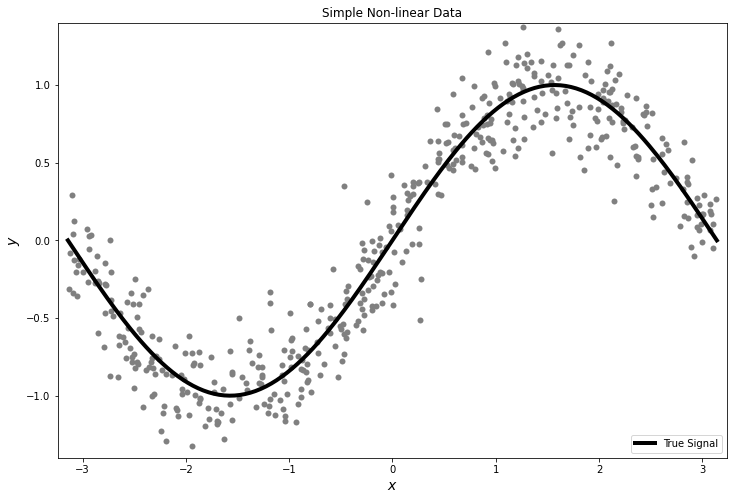

In [13]:
plot_data(); plot_truth()
plt.title('Simple Non-linear Data')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
_ = plt.legend(loc="lower right")
# plt.savefig('plots/sin-with-data.png', bbox_inches='tight')

In [14]:
N_ESTIMATORS = 500 # used later in model fitting
# Fit a gradient boosted regressor to this function 
#     and plot both the functiona and f
model = GradientBoostingRegressor(learning_rate=0.01, 
                                  n_estimators=N_ESTIMATORS, #boosting stages to perform
                                  max_depth=3)
model.fit(to_column(xs), ys)

y_hat = model.predict(to_column(x))

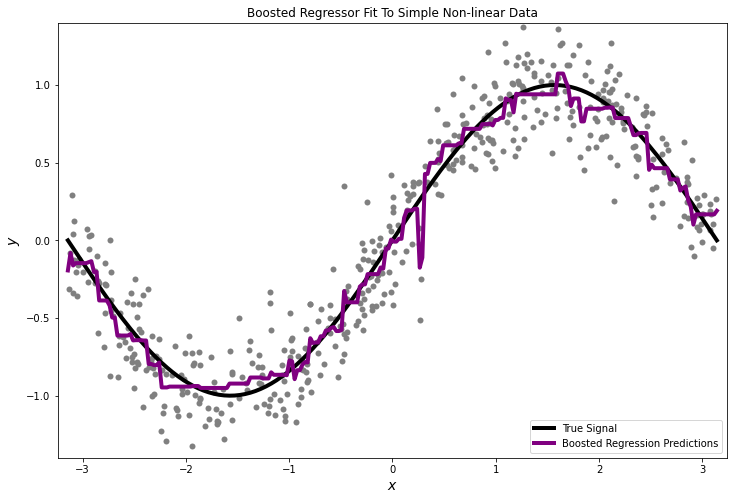

In [15]:
plot_data(); plot_truth()
plt.plot(x, y_hat, 
         color='purple', 
         linewidth=4, 
         label="Boosted Regression Predictions")
plt.title('Boosted Regressor Fit To Simple Non-linear Data')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
_ = plt.legend(loc="lower right")

# plt.savefig('plots/sin-with-data-and-booster.png', bbox_inches='tight')

##### Boosting accomplishes this by growing the model gradually

In [20]:
len(models), 500/25

(500, 20.0)

Text(0.5, 0.98, 'Boosting Statges Over Time')

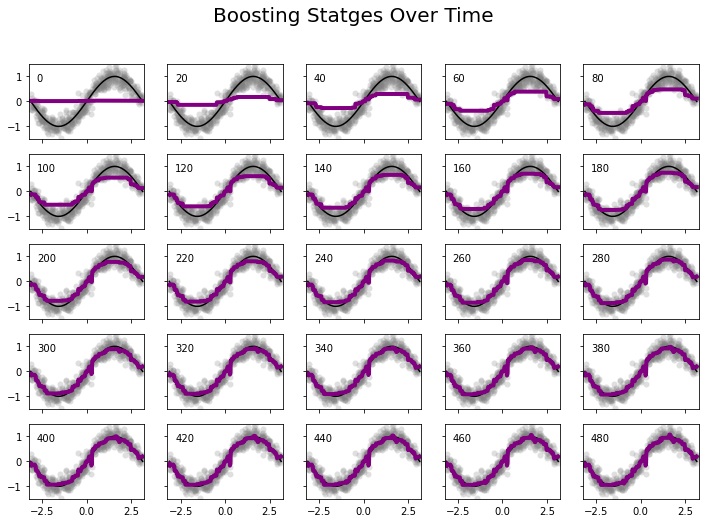

In [21]:
# Plot the partial sums of the weak learners to see what is going on.
# The point: the model learns gradually!
models = list(model.staged_predict(to_column(x)))
fig, axes = plt.subplots(nrows=5, ncols=5, 
                         sharex=True, sharey=True, 
                         figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xs, ys, 'o', color='grey', 
            markeredgewidth=0, alpha=0.25)
    l1 = ax.plot(x, y, color = 'black')
    # increase by 15 out of a total 500
    l2 = ax.plot(x, models[20*i], color="purple", linewidth=4)
    ax.text(-2.8, 0.8, str(20*i))
    
plt.xlim(-np.pi-pad, np.pi+pad); plt.ylim([-1.5, 1.5])    
plt.suptitle("Boosting Statges Over Time", fontsize=20)
# plt.tight_layout()
# plt.savefig('plots/boosting-over-time-multiple-plots.png', bbox_inches='tight')

At each stage of the growth, the next model is built as a small adjustment to the previous model

In [25]:
16%15

1

Text(0.5, 1.0, 'Boosting Statges Over Time')

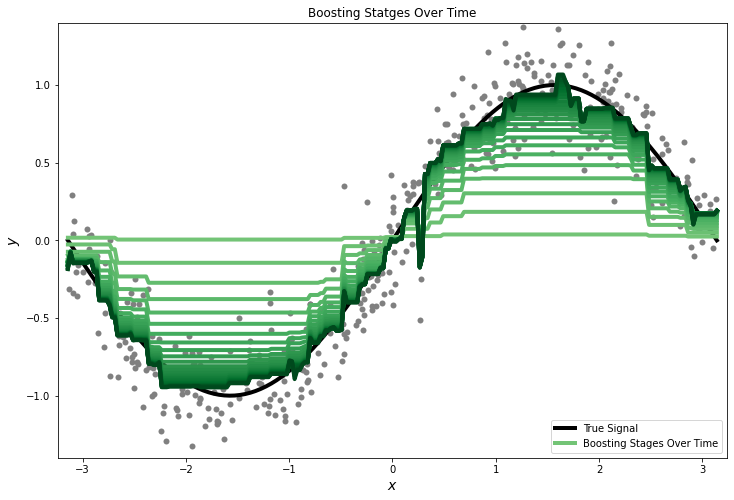

In [27]:
plot_data(); plot_truth()

label = "Boosting Stages Over Time"
for i, pred in enumerate(model.staged_predict(to_column(x))):
    if i % 20 == 1:
        plt.plot(x, pred, color=plt.cm.Greens(i/1000 + 0.5),
                 linewidth=4,
                 label=label)
        label = None
        
plt.legend(loc="lower right")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.title("Boosting Statges Over Time")
# plt.savefig('plots/boosting-over-time-single-plot.png', bbox_inches='tight')

In [28]:
## Different function!
# Boosting can even handle complex, discontinuous loss functions
f_discontinuous = lambda x: f(x) + (x >= -0.75*np.pi)*(x <= -0.25*np.pi) - (x >= 0.5*np.pi)
y_discontinuous = f_discontinuous(x)
ys_discontinuous = f_discontinuous(xs) + rand.normal(0, 0.20, N)

def plot_discontinuous_truth():
    plt.plot(x, y_discontinuous, 
             linewidth = 4,
             color = 'black', label="True Signal")
    plt.xlim(-np.pi-pad, np.pi+pad); plt.ylim([-1.5, 1.5])
    
def plot_discontinuous_data():
    plt.plot(xs, ys_discontinuous,
             'o', color='grey', markeredgewidth=0)
## model fitting
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000)
model.fit(to_column(xs), ys_discontinuous)
# predictions
y_hat = model.predict(to_column(x))

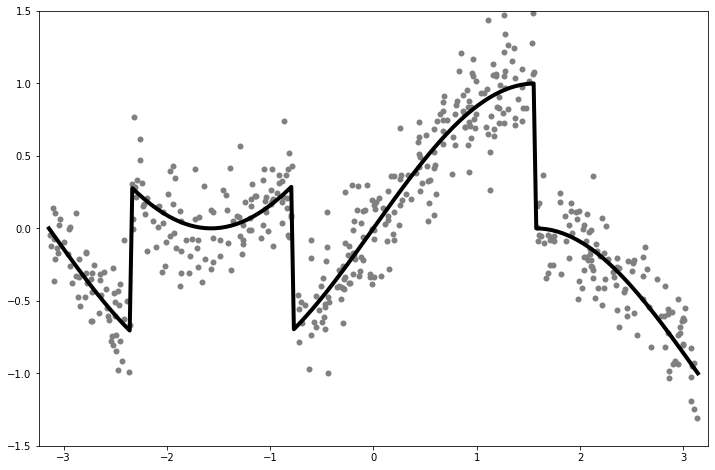

In [29]:
plot_discontinuous_data(); plot_discontinuous_truth()
plt.plot(x, y_hat, color='purple', linewidth=4, label="Boosted Regression Predictions")
plt.title("Boosting Towards a Discontinuous Ojective")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="upper left")

# plt.savefig('plots/broken-sin-with-booster.png', bbox_inches='tight')

### Variance vs Bias
Boosting
 - Lowers variance by growing the model slowly over time (along with a few
other tricks).
 - Lowers bias by stacking many small models into the final result.
 
Compared to 

Linear Models:
 - Lowers variance by [You fill it up]
 - Lowers bias by [You fill it up]
 
Compared to 

Random Forest:
 - Lowers variance by [You fill it up]
 - Lowers bias by [You fill it up]

### Boosting to Residuals
What does boosting really do?

Let's start with our usual basic setup. 

 - $n$: number of training samples
 - $p$: number of features / predictors
 - $\{x_i, y_i\}$ is a labeled data set, where $i$ indexes the samples we have available for training; and $x_i$ is a vector of length $p$.
 
Our goal is to construct a function $f$ so that 
$$
y_i \approx f(x_i) \quad \forall i
$$

More precisely, we look to minimize the MSE/RSS 
$$
\sum_i (y_i - f(x))^2
$$

As we saw in the introduction, we would like to build up $f$ in stages, making small adjustments as we go. 

In the end, $f$ will be a sum of *weak learners*
$$
f(x) = f_0(x) + f_1(x) + f_2(x) + \dots + f_{\max}(x)
$$

**But where should we start?**

We want to make the simplest possible choice for our first stage
$$f_0(x) = \text{constant}$$

But what constant???

We are trying to minimize the sum of squared errors, so a good choice would be to find the constant minimizing
$$
\sum_i (y_i - \text{constant})^2
$$

**Question:** What is the natural choice here?

<font color="white">$f_0(x) = \bar y_i = \frac{1}{n} \sum_i y_i$</font>

### How to update

In [31]:
np.random.seed(seed=200)

N = 12  # number of points
# Ground truth
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)
# Data
xs = np.linspace(-np.pi, np.pi, 12)
ys = f(xs) + rand.normal(0, 0.20, N)
# sample mean
mu = np.mean(ys)
mu

0.049752901625927715

In [32]:
def plot_data(x, y, xs, ys, zero = True, hideSignal = False):
    '''
    plot the true signal
    plot the training data
    define xlim & ylim
    '''
    if (not hideSignal):
        plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
    plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
    if zero:
        # add zero-th stage horizontal line
        plt.hlines(mu, xmin = -np.pi, xmax = np.pi, label="$f_0(x)$", colors="r") 
    plt.xlim([-np.pi-pad, np.pi+pad]); plt.ylim([-1.4, 1.4])
    plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
    plt.legend(loc="lower right")
def plot_formatting():
    '''
    format xlim & ylim, label fontsize, legend position
    '''
    plt.xlim([-np.pi-pad, np.pi+pad]); plt.ylim([-1.4, 1.4])
    plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
    plt.legend(loc="lower right")

Text(0.5, 1.0, 'The Zero-th Boosting Stage')

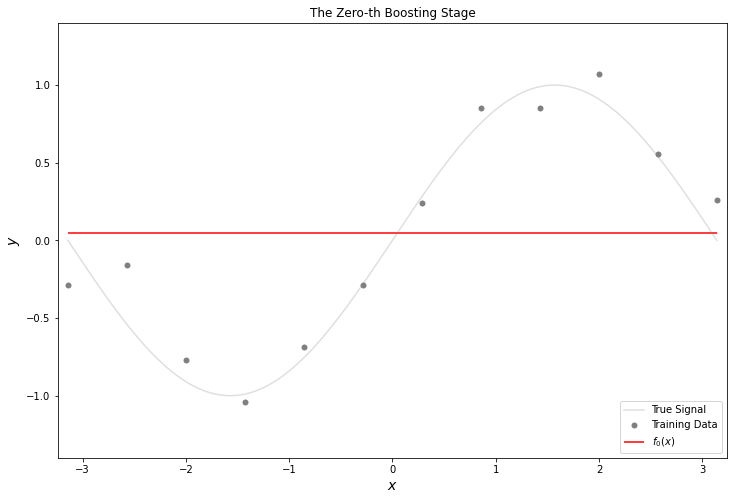

In [33]:
## plot
plot_data(x, y, xs, ys)
## add-ons
plt.title('The Zero-th Boosting Stage')
# plt.savefig('plots/zeroth-boosting-stage.png', bbox_inches='tight')

We are now in the situation illustrated above; our next task is to update our simple $f_0(x)$ to $f_0(x) + f_1(x)$. Intuitively, it's obvious what we should do:

In [34]:
# Effect of different learning rates
model_no_lr   = GradientBoostingRegressor(n_estimators=6, 
                                          learning_rate=1.0, 
                                          max_depth=2)
model_with_lr = GradientBoostingRegressor(n_estimators=600, 
                                          learning_rate=0.01,
                                          max_depth=2)
model_no_lr.fit(to_column(xs), ys)
model_with_lr.fit(to_column(xs), ys)
## on all 250 points
model_no_lr_preds = list(model_no_lr.staged_predict(to_column(x)))
## on 12 points in the sample
model_no_lr_preds_at_training = list(model_no_lr.staged_predict(to_column(xs)))

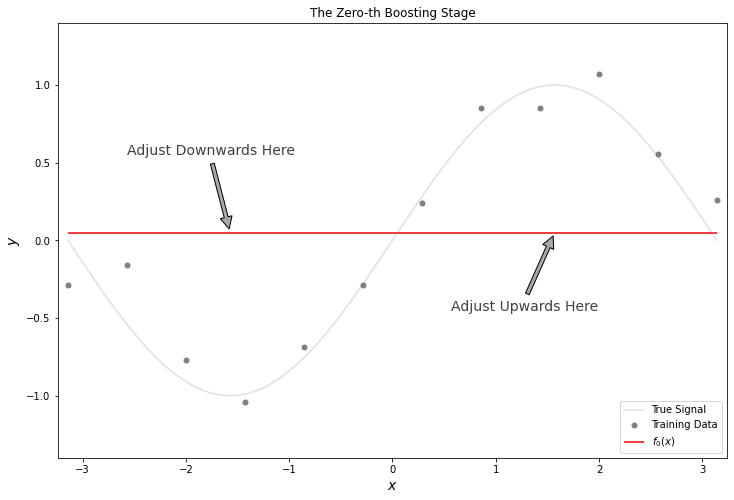

In [35]:
plot_data(x, y, xs, ys)
## add-ons
left_arrow_pos = [-np.pi / 2, mu]
plt.annotate('Adjust Downwards Here', left_arrow_pos,
              xytext=(left_arrow_pos[0] - 1, left_arrow_pos[1] + 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75)

right_arrow_pos = [np.pi / 2, mu]
plt.annotate('Adjust Upwards Here', right_arrow_pos,
              xytext=(right_arrow_pos[0] - 1, right_arrow_pos[1] - 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75)

_ = plt.title('The Zero-th Boosting Stage')
# plt.savefig('plots/zeroth-boosting-stage-what-to-do.png', bbox_inches='tight')

But how can we use *the data* to tell us this? We won't always have the luxury of such simple pictures. 

Take a moment to think: how is the data is telling us what to do?

The *residuals!* $y_i - f_0(x_i)$ answers this question!

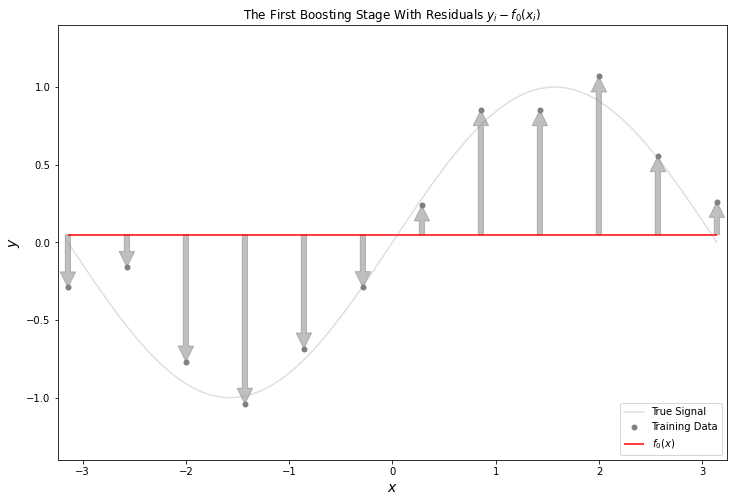

In [36]:
plot_data(x, y, xs, ys)
## add-ons: residuals
for px, py in zip(xs, ys):
    plt.arrow(px, mu, 0, py - mu, color='grey', alpha=0.5,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')

_ = plt.title('The First Boosting Stage With Residuals $y_i - f_0(x_i)$')
# plt.savefig('plots/first-boosting-stage-with-residuals.png', bbox_inches='tight')

**We should adjust $f_0(x)$ in the direction of the residuals!**

But... there is a big issue with this...

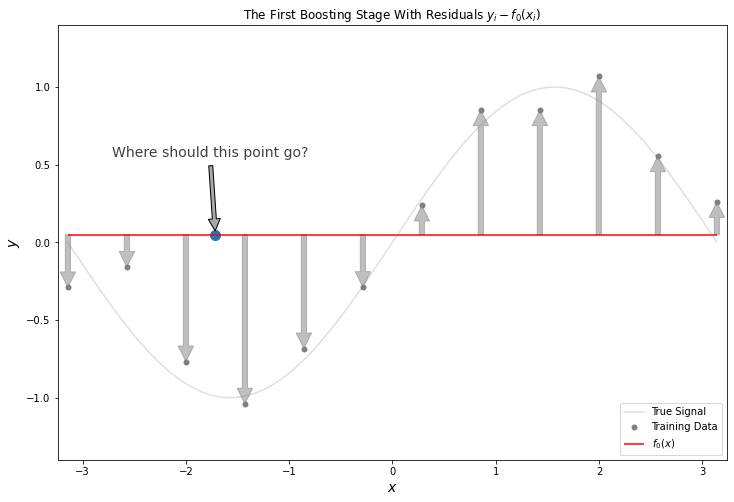

In [37]:
plot_data(x, y, xs, ys)
## add-ons: residuals
for px, py in zip(xs, ys):
    plt.arrow(px, mu, 0, py - mu, color='grey', alpha=0.5,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')
## add-ons: text annotations
arrow_pos = (xs[2] + (xs[3] - xs[2])/2, mu)
plt.scatter([arrow_pos[0]], [arrow_pos[1]], s=100)
plt.annotate('Where should this point go?', arrow_pos,
              xytext=(arrow_pos[0] - 1, arrow_pos[1] + 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14, alpha=0.75)
_ = plt.title('The First Boosting Stage With Residuals $y_i - f_0(x_i)$')
# plt.savefig('plots/first-boosting-stage-with-residuals-dillema.png', bbox_inches='tight')

We can only calculate residuals at the *training data points*!

We need some way of **extending** the values of the residuals to places we *do not have data*.

**Solution**:

Fit a model to the residuals!

The **predictions from this model** both:

- Approximate the residuals at the places as we *have* data
- Are defined everywhere

Here's a *new* dataset. 

- The values of $x$ are the same as before, taken directly from the training data.
- The response values are the residuals: $y_{\text{new}} = y_i − f_0(x)$.

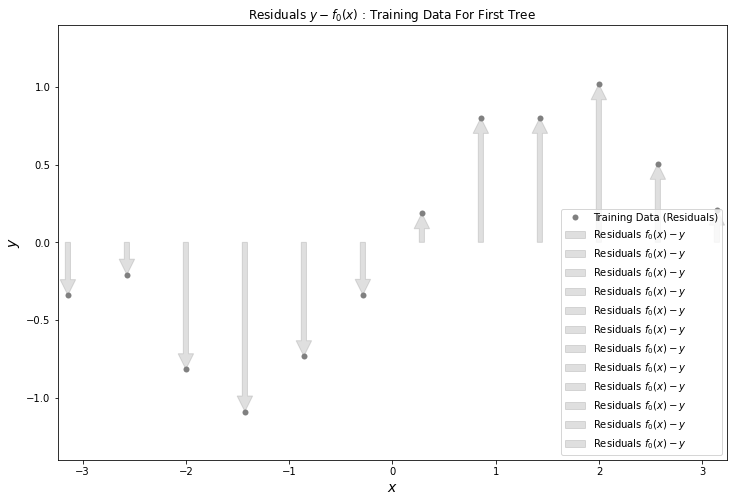

In [38]:
residuals_0 = ys - mu 

plt.plot(xs, residuals_0, 'o', markeredgewidth=0, color="grey",
         label='Training Data (Residuals)')

for px, py in zip(xs, residuals_0):
    plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')

plot_formatting()
_ = plt.title('Residuals $y - f_0(x)$ : Training Data For First Tree')
# plt.savefig('plots/first-boosting-stage-residual-training-set.png', bbox_inches='tight')

Here is a very simple model fit to this *working data set*

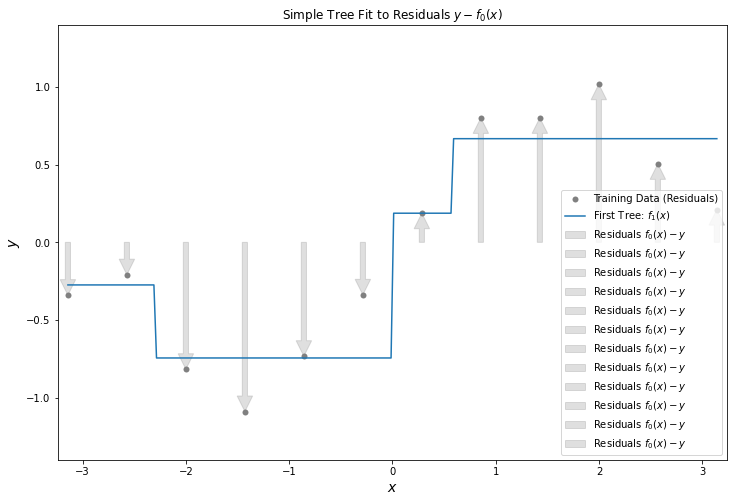

In [42]:
wl_preds_0 = model_no_lr_preds[0] - mu

plt.plot(xs, residuals_0,
         'o', markeredgewidth=0, color="grey", 
         label='Training Data (Residuals)')
plt.plot(x, wl_preds_0,
         label="First Tree: $f_1(x)$")

for px, py in zip(xs, residuals_0):
    plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')
plot_formatting()
_ = plt.title('Simple Tree Fit to Residuals $y - f_0(x)$')
# plt.savefig('plots/first-boosting-stage-residuals-with-tree.png', bbox_inches='tight')

Now we can update the model, call is $S_i$

$S_1(x) = f_0(x) + f_1(x) \longleftarrow $ Model fit to residuals!


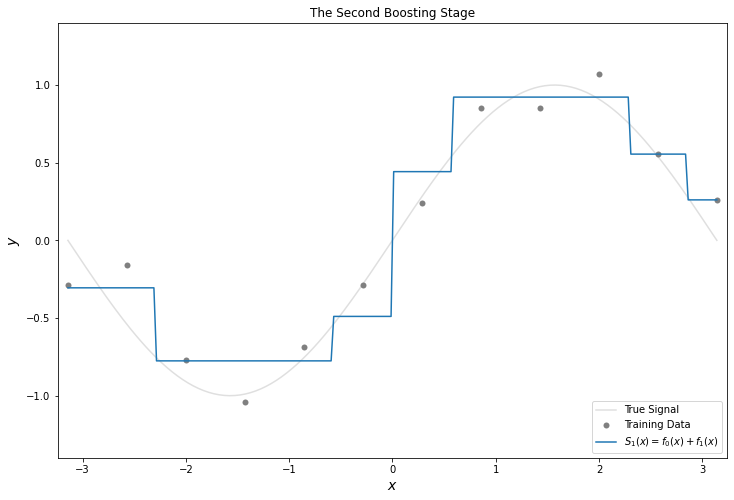

In [43]:
plot_data(x, y, xs, ys, zero=False)

plt.plot(x, model_no_lr_preds[1], label="$S_1(x) = f_0(x) + f_1(x)$")

plt.title('The Second Boosting Stage')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])
plot_formatting()

# plt.savefig('plots/second-boosting-stage.png', bbox_inches='tight')

Let’s go one more step, so that the idea is clear.

Calculate the residuals of the current model...

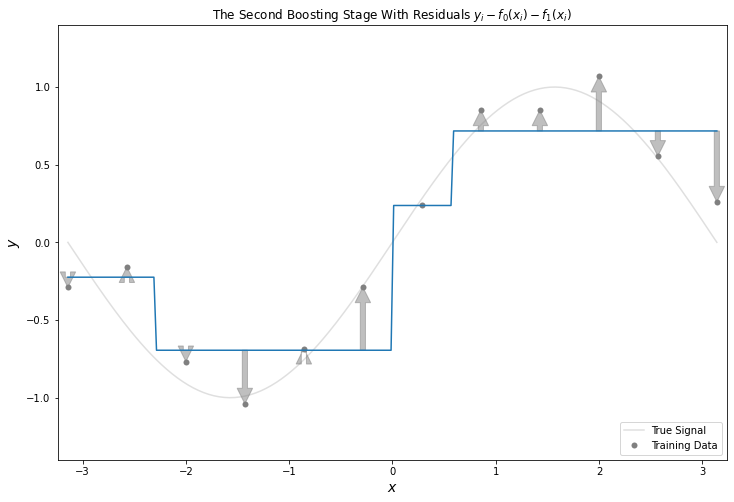

In [48]:
plot_data(x, y, xs, ys, zero=False)
## add-ons
residuals_1 = ys - model_no_lr_preds_at_training[0]
plt.plot(x, model_no_lr_preds[0], label="$S_1(x) = f_0(x) + f_1(x)$")

for px, py, pp in zip(xs, ys, model_no_lr_preds_at_training[0]):
    try:
        # Arrows of length zero are unhappy
        plt.arrow(px, pp, 0, py - pp,
                  color='grey', alpha=0.5,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

_ = plt.title('The Second Boosting Stage With Residuals $y_i - f_0(x_i) - f_1(x_i)$')
# plt.savefig('plots/second-boosting-stage-with-residuals.png', bbox_inches='tight')

Create a training data set with the residuals as the response...

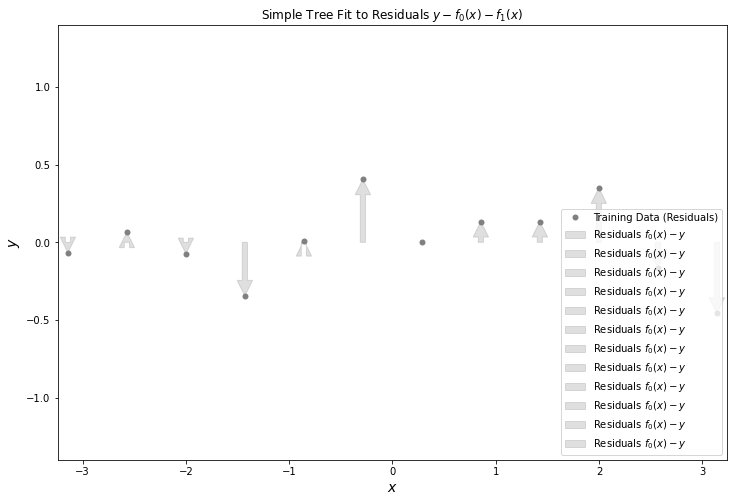

In [49]:
wl_preds_1 = model_no_lr_preds[1] - model_no_lr_preds[0]

plt.plot(xs, residuals_1, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')

for px, py in zip(xs, residuals_1):
    try:
        plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('Simple Tree Fit to Residuals $y - f_0(x) - f_1(x)$')
plot_formatting()
# plt.savefig('plots/second-boosting-stage-residual-training-set.png', bbox_inches='tight')

Create a training data set with the residuals as the response...

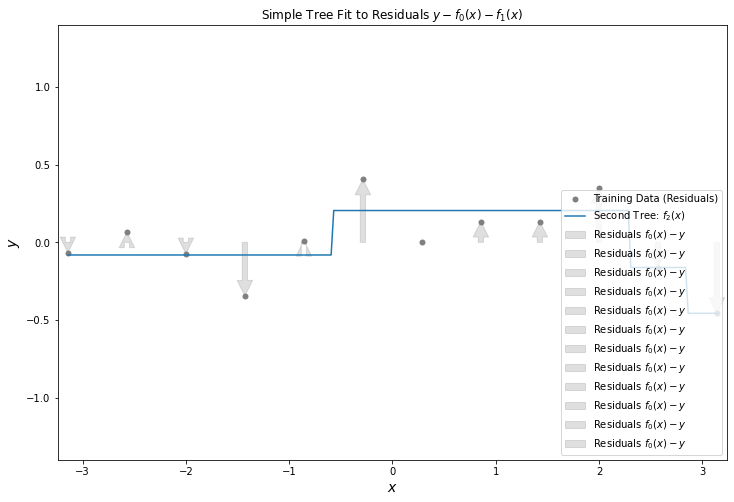

In [50]:
wl_preds_1 = model_no_lr_preds[1] - model_no_lr_preds[0]

plt.plot(xs, residuals_1, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')
plt.plot(x, wl_preds_1, label="Second Tree: $f_2(x)$")

for px, py in zip(xs, residuals_1):
    try:
        plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('Simple Tree Fit to Residuals $y - f_0(x) - f_1(x)$')
plot_formatting()
# plt.savefig('plots/second-boosting-stage-residuals-with-tree.png', bbox_inches='tight')

Update the model!

Text(0.5, 1.0, 'The Third Boosting Stage')

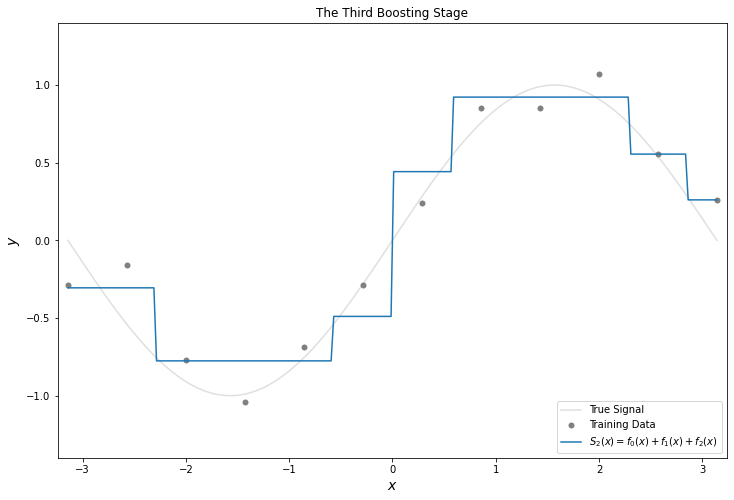

In [51]:
plot_data(x, y, xs, ys, zero=False)
plt.plot(x, model_no_lr_preds[1], label="$S_2(x) = f_0(x) + f_1(x) + f_2(x)$")
plot_formatting() # call again for the last legend
plt.title('The Third Boosting Stage')
# plt.savefig('plots/third-boosting-stage.png', bbox_inches='tight')

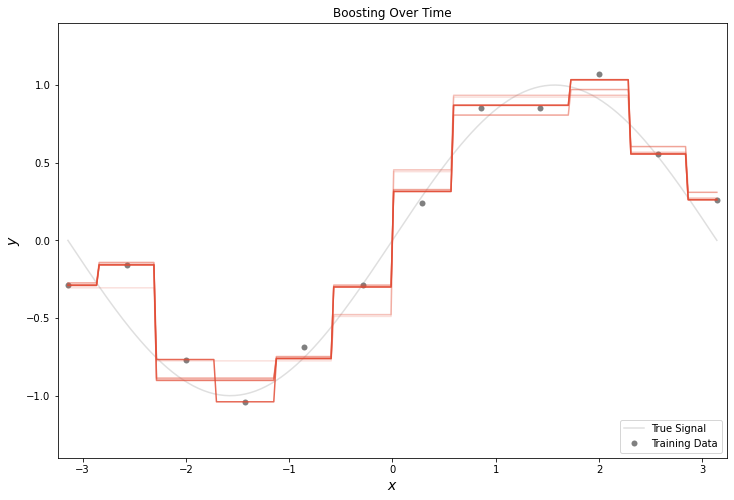

In [52]:
plot_data(x, y, xs, ys, zero=False)
for i, py in enumerate(model_no_lr.staged_predict(to_column(x))): 
    plt.plot(x, py, color='#E24A33', 
             alpha= float(i)/model_no_lr.n_estimators)

plt.title('Boosting Over Time')
_ = plt.savefig('simple-boosting-over-time.png', bbox_inches='tight')

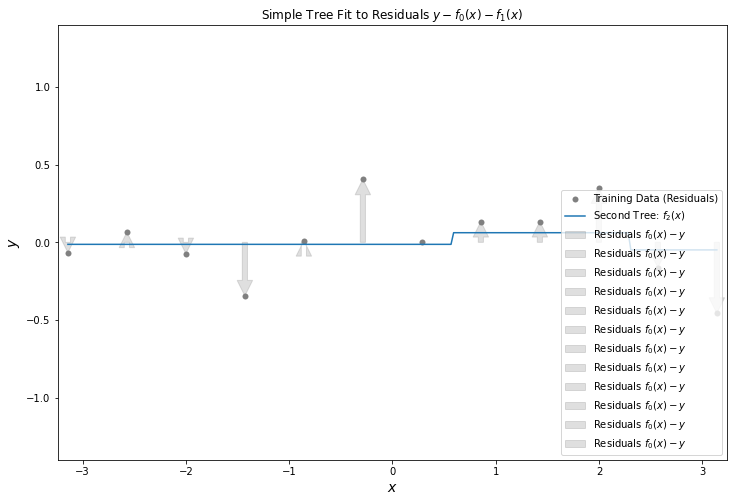

In [60]:
wl_preds_1 = model_no_lr_preds[4] - model_no_lr_preds[3] 
- model_no_lr_preds[2] - model_no_lr_preds[1] - model_no_lr_preds[0]

plt.plot(xs, residuals_1, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')
plt.plot(x, wl_preds_1, label="Second Tree: $f_2(x)$")

for px, py in zip(xs, residuals_1):
    try:
        plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('Simple Tree Fit to Residuals $y - f_0(x) - f_1(x)$')
plot_formatting()

**But, What Happened to Growing Slowly Over Time?**

Instead of adding in the entirety of the residual fitted tree during an update
$$S_{k+1} (x) = S_k(x) + f_{k+1}(x)$$

Instead we added some *small fraction* of $f_{k+1}$
$$S_{k+1} (x) = S_k(x) + \lambda f_{k+1}(x)$$

For instance, take $\lambda = .01$

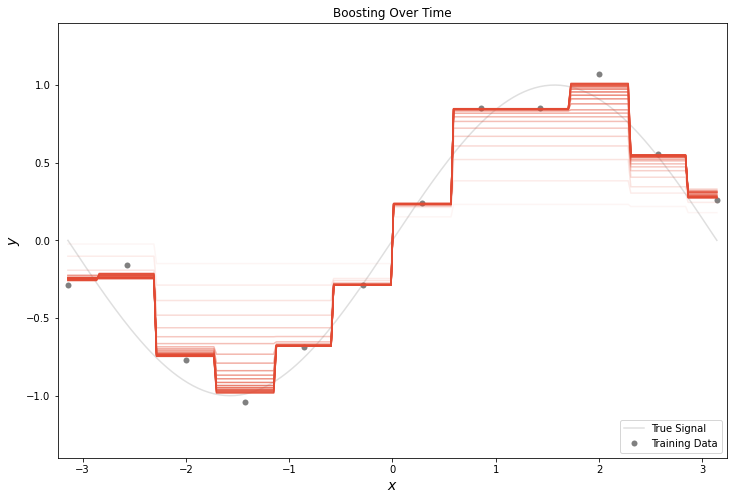

In [53]:
plot_data(x, y, xs, ys, zero=False)
# with learning rate 600 trees
for i, py in enumerate(model_with_lr.staged_predict(to_column(x))):
    if i % 30 == 0:
        plt.plot(x, py, 
                 color='#E24A33',
                 alpha=(float(i)/model_with_lr.n_estimators))

_ = plt.title('Boosting Over Time')
# plt.savefig('plots/simple-boosting-over-time-learning-rate.png', bbox_inches='tight')

Gradient Boosting to Minimize Sum of Squared Errors

**Input**: A training data set $\{x_i, y_i\}$, and a learning rate $\lambda$.

**Returns**: A function $f$ such that $f(x_i)\approx y_i$

- initialize $S_0(x) = f_0(x) = \frac1n \sum_i y_i$
- iterate (parameter $k$) until satisfied
    - create the working data set $W_k = \{x_i, \quad y_i - S_k(x_i)\}$
    - fit a regression tree to $W_k$, minimizing least squares. Call this tree $f_k$
    - set $S_{k+1} (x) = S_k(x) + \lambda f_k(x)$
- return $f_{\max} (x) := f_0(x) + f_1(x)+ f_2(x) + \dots + f_{\max}(x)$

### Why is it Called Gradient Boosting? 

Remember when we were in this situation:
![](plots/first-boosting-stage-with-residuals-dillema.png)

We want to use the residuals to update the model 
$$S_{k+1}(x) = S_k (x) + \lambda (y_i - S_k(x))$$

Removing the details of the specific situation, this looks like 
$$S_{k+1}(x) = S_k (x) + \lambda (y_i - S_k(x))$$
$$\Downarrow$$
$$\xi_{k+1}(x) = \xi_k (x) + \lambda (y_i - \xi_k(x))$$

This is why the algorithm is called **Gradient Boosted Regression**.

We ”boost” the current estimate by adding an *approximation to the gradient of the squared error loss function*.

### Gradient boosting in sklearn

Scikit-learn includes the gradient boosted regression algorithm in the ensembles module
```
from sklearn.ensemble import GradientBoostedRegressor
```
A GradientBoostingRegressor object is fit in the same way as every other leaning model in sklearn
```
model = GradientBoostingRegressor() 
model.fit(X, y)
```
The predict method returns predictions on new data 
```
preds = model.predict(X_new)
```

Especially useful is the iterator `staged_predict` which creates predictions from models created by truncating series of trees
```
for preds in model.staged predict(X new):
# Do something interesting , used heavily in the plots
```

## Hyperparameters

GradientBoostingRegressor has many knobs to turn.
```
GradientBoostingRegressor(loss=’ls ’,
                          n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3,
                          subsample=1.0,
                          min_samples_split=2,
                          min_samples_leaf=1,
                          min_weight_fraction_leaf=0.0,
                          ...)
```
The most important options to `GradientBoostedRegressor` are

- `loss` controls the loss function to minimize. `ls` is the least squares
minimization algorithm we discussed in the previous section.
- `n_estimators` is how many boosting stages to compute, i.e., how many regression trees to grow.
- `learning_rate` is the learning rate for the gradient update.
- `max_depth` controls how deep to grow each individual tree.
- `subsample` allows to fit each tree on a random sample of the training data (similar to bagging in random forests).

### Tuning the number of estimators
As more and more trees are added to the model the training set error will be driven down monotonically, but the same is not true for the testing error

In [61]:
## Regression on the boston data set
N_ESTIMATORS = 1000

boston = datasets.load_boston()
X, y, names = boston['data'], boston['target'], boston['feature_names']

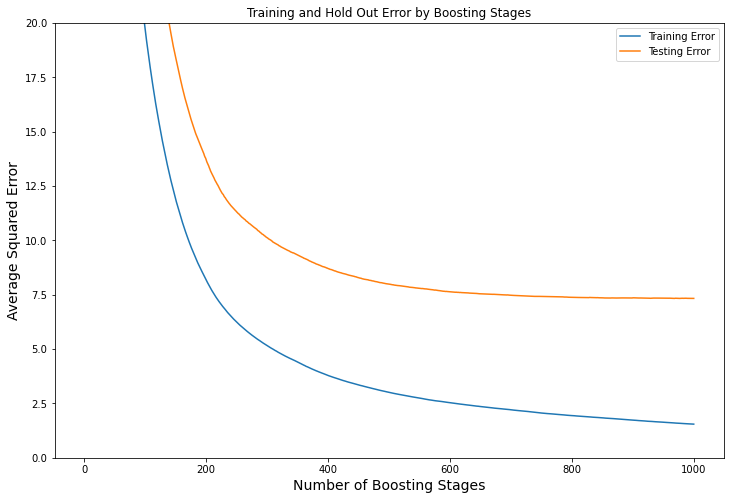

In [62]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)

model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, 
                                  learning_rate=0.01)
model.fit(X_train, y_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
_ = plt.ylim([0, 20])
# plt.savefig('plots/training-and-testing-error.png', bbox_inches='tight')

This means that it is essential to determine the proper number of trees to grow, as too many may lead to overfitting.

One way to tune the number of trees is to make use of a validation set, held out from training the model

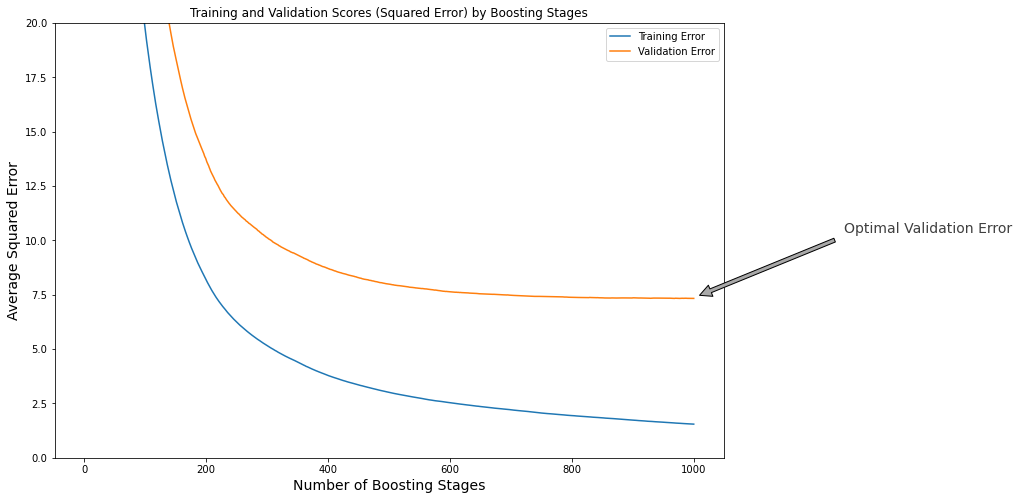

In [63]:
# Estimating the optimal number of boosters using a validation set
optimal_n_trees = np.argmin(test_score)
optimal_score = test_score[optimal_n_trees]

plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Validation Error")

optimal_point = (optimal_n_trees, optimal_score)
plt.annotate('Optimal Validation Error', optimal_point,
              xytext=(optimal_point[0] + 250, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75)

plt.title("Training and Validation Scores (Squared Error) by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
_ = plt.ylim([0, 20])

# plt.savefig('plots/training-and-testing-error-with-optima.png', bbox_inches='tight')

The `loss_` method is important here, it allows us to compute the loss function on held out data.

Once the optimal number of estimators is known, it’s useful to truncate the model.

Another way to choose the optimal number of trees is to replace the validation set with cross validation

In [64]:
# Tuning by cross validation
N_ESTIMATORS = 1000 # 4000
N_FOLDS = 3 # 10

train_scores = np.zeros((N_FOLDS, N_ESTIMATORS))
test_scores  = np.zeros((N_FOLDS, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_index, test_index) in enumerate(folds.split(X)):
    X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]
    model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
    model.fit(X_train, y_train)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_scores[k, i] = model.loss_(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_scores[k, i] = model.loss_(y_test, y_pred)
        
mean_train_score = np.mean(train_scores, axis=0)
mean_test_score  = np.mean(test_scores, axis=0)

optimal_n_trees = np.argmin(mean_test_score)
optimal_score = mean_test_score[optimal_n_trees]
optimal_point = (optimal_n_trees, optimal_score)
_ = os.system('say "your program has finished"')

In [65]:
# Fit a model with optimal values to look at various diagnostic plots
model_opt = GradientBoostingRegressor(n_estimators=optimal_n_trees, 
                                  learning_rate=0.01)
model_opt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=997)

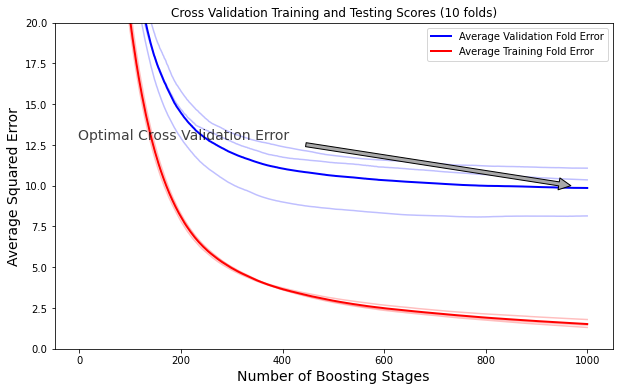

In [66]:
plt.figure(figsize = (10, 6))
for i in range(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, train_scores[i, :], color='red', alpha=0.25)
    
for i in range(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, test_scores[i, :], color='blue', alpha=0.25)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_score, color='blue', linewidth=2,
         label='Average Validation Fold Error')
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_score, color='red', linewidth=2,
         label='Average Training Fold Error')

plt.annotate('Optimal Cross Validation Error', optimal_point,
              xytext=(optimal_point[0] - 1000, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title("Cross Validation Training and Testing Scores (10 folds)")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
_ = plt.ylim([0, 20])

# plt.savefig('plots/training-and-testing-cv-error.png', bbox_inches='tight')

We generally choose the number of trees minimizing the average out validation fold error.

### Tuning the Learning Rate

The learning rate allows us to grow our boosted model slowly.

A large learning rate will cause the model to fit hard to the training data, which creates a *high variance* situation.

A smaller learning rate reduces the boosted models sensitivity to the training data.

In [76]:
np.ones((2,3,4)).sum(axis=0)

array([[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]])

In [69]:
# Varying the learning rate
N_ESTIMATORS = 1000
N_FOLDS = 3

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(folds.split(X)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
    
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
mean_test_scores = np.mean(test_scores, axis=0)

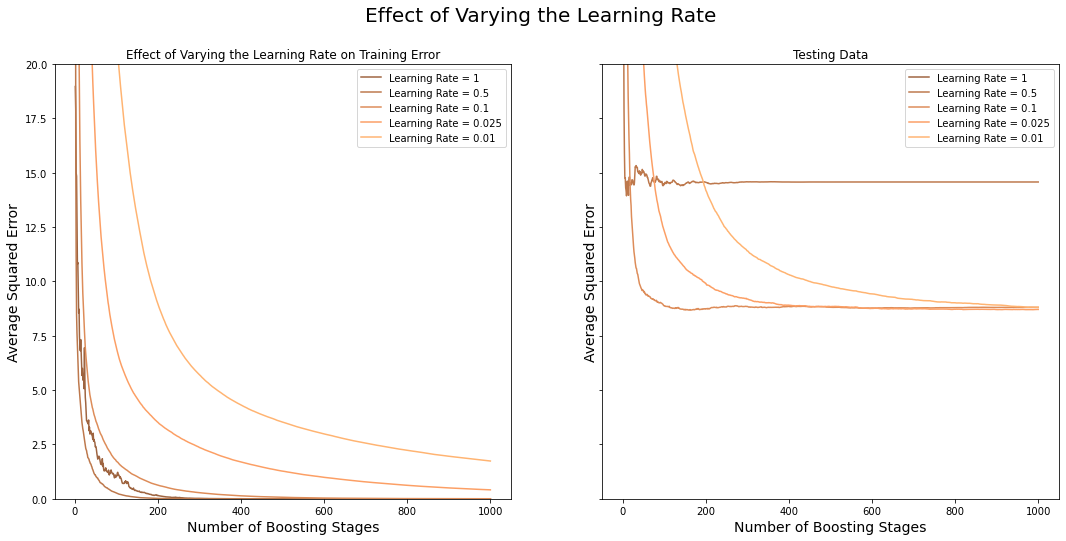

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                         figsize=(18.0, 8.0))
 
for i, rate in enumerate(learning_rates):    
    ## train scores
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
    ## test scores
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
## common format
for ax in axes:
    ax.legend(loc = "upper right")
    ax.set_xlabel('Number of Boosting Stages', fontsize=14)
    ax.set_ylabel('Average Squared Error', fontsize=14)
## subplot titles
axes[0].set_title("Effect of Varying the Learning Rate on Training Error")
axes[1].set_title("Testing Data")

plt.ylim([0, 20])
_ = plt.suptitle("Effect of Varying the Learning Rate", fontsize=20)
# plt.savefig('plots/varying-learning-rate-error.png', bbox_inches='tight')

Decreasing the learning rate reduces how fast the booster drives down the training error rate (see figures above).

On the other hand, a smaller learning rate means more trees are needed to reach the optimal point.

In general, a smaller learning rate eventually (over enough time) results in a superior model

**Strategy for Tuning Learning Rate**
- In the initial exploratory phases of modeling, set the learning rate to some large value, say 0.1. This allows you to iterate through ideas quickly.
- When tuning other parameters using grid search, decrease the learning rate to a more sensible value, 0.01 works well.
- When fitting the *final* production model, set the learning rate to a very small value, 0.001 or 0.0005, smaller is better.


**General Advice:**
Run the final model overnight! It will fit while you are sleeping!

Make sure you’ve written all your analysis code up front, based on your initial models. Then all that’s left is to run your final model through and see your final plots and statistics.

### Tuning the Tree Depth
A larger tree depth allows the model to capture deeper interactions between the predictors, resulting in lower bias

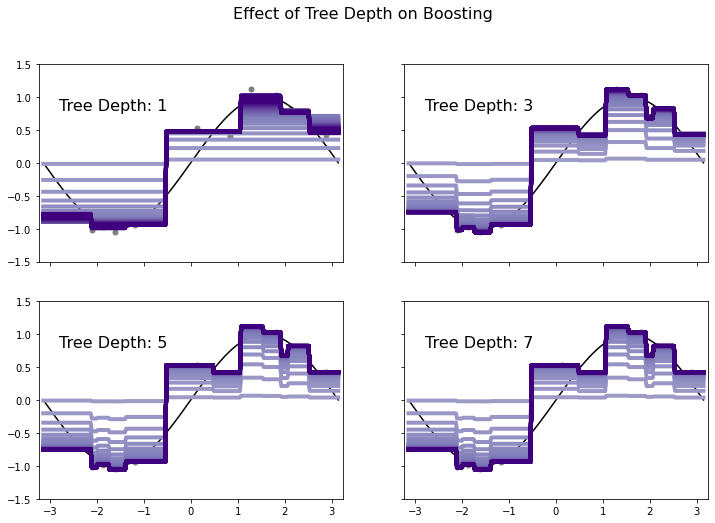

In [77]:
N_ESTIMATORS = 1000 # tree depth is more influential
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

## Add some noise
xs = rand.uniform(-np.pi, np.pi, N)
ys = f(xs) + rand.normal(0, 0.20, N)
# Effect of changing tree depth
tree_depths = [1, 3, 5, 7]
models = [GradientBoostingRegressor(learning_rate=0.02, # tune this as well to see the differences
                                    n_estimators=N_ESTIMATORS, 
                                    max_depth=td) 
          for td in tree_depths]
for model in models:
    model.fit(to_column(xs), ys)
    
fig, axes = plt.subplots(nrows=2, ncols=2, 
                         sharex=True, sharey=True, 
                         figsize=(12, 8))

for i, (depth, ax) in enumerate(zip(tree_depths, axes.flatten())):
    ax.plot(xs, ys, 'o', color='grey', markeredgewidth=0)
    ax.plot(x, y, color = 'black', label="True Signal")
    for j, pred in enumerate(models[i].staged_predict(to_column(x))):
        if j % 15 == 1:
            ax.plot(x, pred, 
                    color=plt.cm.Purples(float(j) / 1000 + 0.5), 
                    linewidth=4)
    ax.text(-2.8, 0.8, "Tree Depth: " + str(depth), fontsize=16)
    
plt.suptitle("Effect of Tree Depth on Boosting", fontsize=16)
plt.xlim(-np.pi-pad, np.pi+pad)
_ = plt.ylim([-1.5, 1.5])
# plt.savefig('plots/sin-changing-depth.png', bbox_inches='tight')

A deeper tree depth also
- Causes the model to fit faster, increasing the variance and somewhat combating the effect of the learning rate.
- Allows the model to assume a more complex structure of the same number of trees. This is a blessing (low bias) and curse (high variance).

In [78]:
# reset to Boston data
X, y, names = boston['data'], boston['target'], boston['feature_names']

In [79]:
# Varying the tree depth rate
N_ESTIMATORS = 3000
N_FOLDS = 3

tree_depths = [1, 3, 5, 7, 9]
N_TREE_DEPTHS = len(tree_depths)

test_scores = np.zeros((N_FOLDS, N_TREE_DEPTHS, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(folds.split(X)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=td, learning_rate=0.01, subsample=0.5,
                                        random_state=154)
              for td in tree_depths]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)
        
mean_test_scores = np.mean(test_scores, axis=0)
_ = os.system('say "your program has finished"')

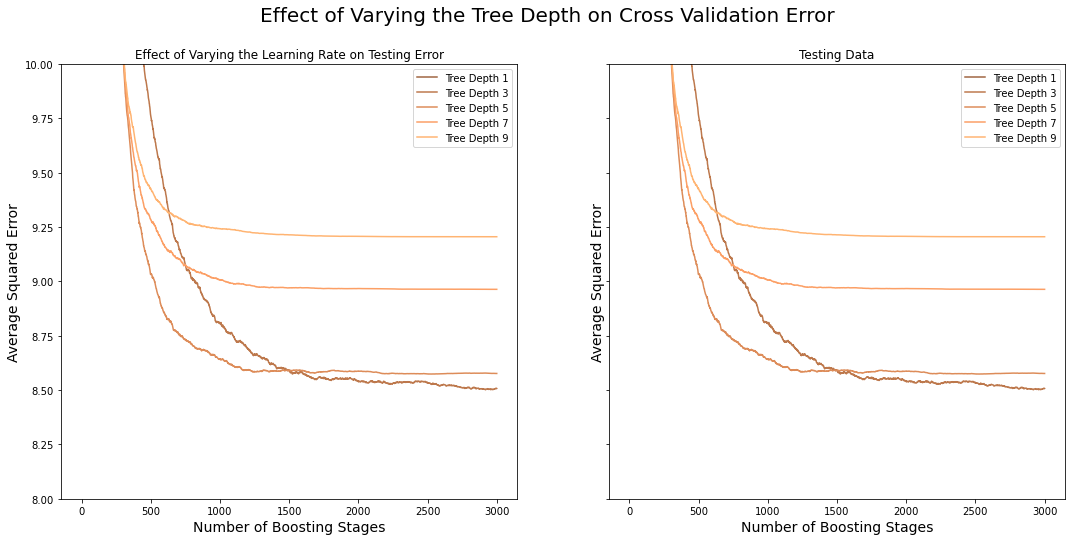

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex=False, sharey=True, 
                         figsize=(18, 8))
 
for i, depth in enumerate(tree_depths):  
    ## all scores
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Tree Depth " + str(depth))
    ## all scores
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Tree Depth " + str(depth))
## common format
for ax in axes:
    ax.legend(loc = "upper right")
    ax.set_xlabel('Number of Boosting Stages', fontsize=14)
    ax.set_ylabel('Average Squared Error', fontsize=14)
## subplot 
axes[0].set_ylim([0, 40])
axes[0].set_title("Effect of Varying the Learning Rate on Testing Error")
axes[1].set_ylim([8, 10])
axes[1].set_title("Testing Data")

_ = plt.suptitle("Effect of Varying the Tree Depth on Cross Validation Error", fontsize=20)
# plt.savefig('plots/varying-tree-depth-error.png', bbox_inches='tight')

It’s never obvious up front what tree depth is best for a given problem, so a grid search is needed to determine the best value. 

**Strategy for Tuning Tree Depth**:
Tune with a grid search and cross validation.

### Tuning the Subsample Rate
The `subsample` parameter allows one to train each tree on a subsample of the training data.

This is similar to bagging in the random forest algorithm, and has the same result: it lowers the variance of the resulting model.

In [81]:
# Varying the subsample rate
N_ESTIMATORS = 3000
N_FOLDS = 3

subsample_rates = [1, 0.8, 0.6, 0.4, 0.2]
N_SUBSAMPLE_RATES = len(subsample_rates)

test_scores = np.zeros((N_FOLDS, N_SUBSAMPLE_RATES, N_ESTIMATORS))

folds = cv.KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(folds.split(X)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=0.01, subsample=sr,
                                        random_state=154)
              for sr in subsample_rates]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)
        
mean_test_scores = np.mean(test_scores, axis=0)
_ = os.system('say "your program has finished"')

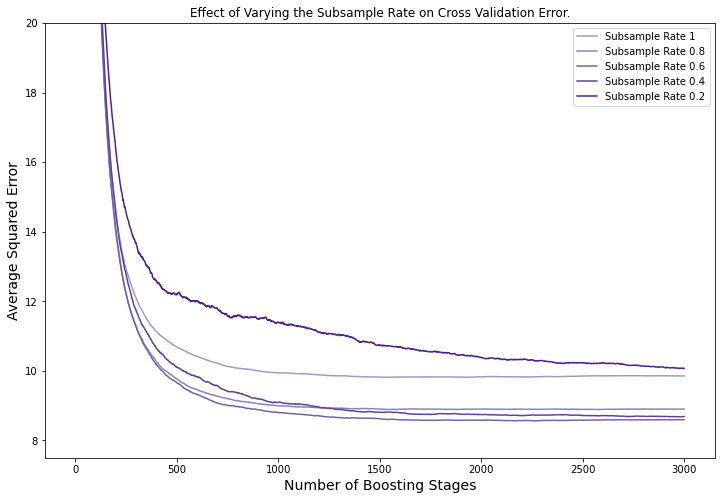

In [84]:
for i, rate in enumerate(subsample_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.Purples(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Subsample Rate on Cross Validation Error.")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

_ = plt.ylim([7.5, 20])
# plt.savefig('plots/varying-subsample-rate-error.png', bbox_inches='tight')

Not subsampling at all, or over subsampling are both bad ideas

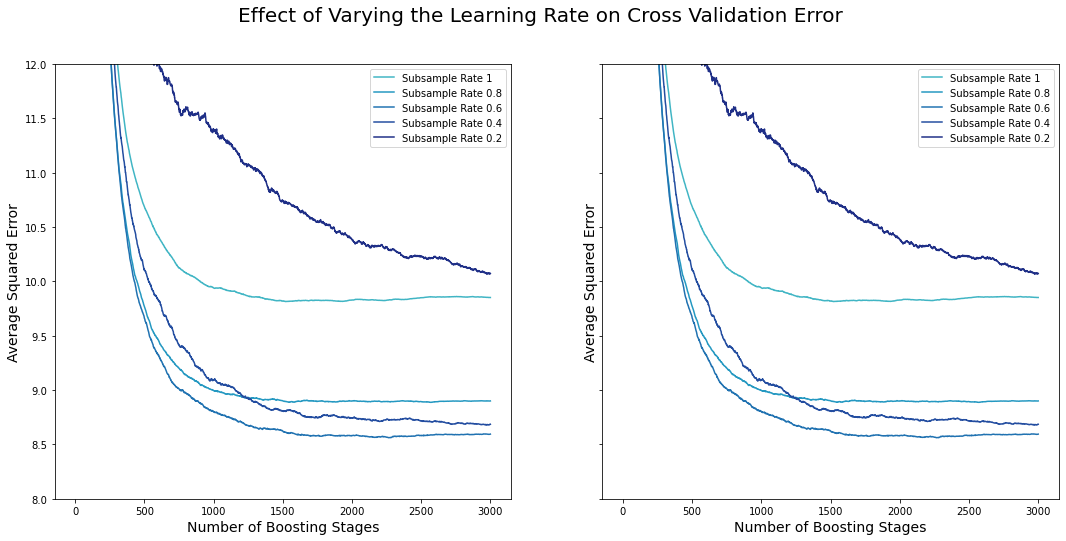

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         sharex=False, sharey=True, 
                         figsize=(18, 8))
## subplot 
axes[0].set_ylim([0, 40])
axes[0].set_title("Effect of Varying the Learning Rate on Testing Error")
# axes[1].set_xlim([3500, 4000])
axes[1].set_ylim([8, 10])
axes[1].set_title("Testing Data")

for i, rate in enumerate(subsample_rates):        
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.YlGnBu(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.YlGnBu(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
## common format
for ax in axes:
    ax.legend(loc = "upper right")
    ax.set_xlabel('Number of Boosting Stages', fontsize=14)
    ax.set_ylabel('Average Squared Error', fontsize=14)
## subplot 
# axes[1].set_xlim([0, 1000])
axes[0].set_ylim([7.5, 20])
axes[0].set_title("")
# axes[1].set_xlim([3500, 4000])
axes[1].set_ylim([8, 12])
axes[1].set_title("")
_ = plt.suptitle("Effect of Varying the Learning Rate on Cross Validation Error", fontsize=20)
# plt.savefig('plots/varying-subsample-rate-error-zoom-start.png', bbox_inches='tight')

Between these two extremes, different levels of subsampling generally give the same performance.

**Strategy For Tuning Subsample**
Set to 0.5, it almost always works well.

If you have a massive amount of data and want the model to fit more
quickly, decrease this value.

**Note**: The default rate in sklearn is 1.0, so make sure you always change it.

### Tuning Other Gradient Boosting Parameters
The other parameters to GradientBoostingRegressor are less important, but can be tuned with grid search for additional improvements in importance.

- `min_samples_split`: Any node with less samples than this will not be considered for splitting.
- `min_samples_leaf`: All terminal nodes must contain more samples than this.
- `min_weight_fraction_leaf`: Same as above, but expressed as a fraction of the total number of training samples.

Generally these are less important because you shouldn’t be growing super gigantic trees!

**Question**: Is there any risk to including these parameters in a grid search and selecting the best using cross validation?


If you do decide to include these in a grid search, be wary of overfitting to your validation set.

The number of model comparisons grows exponentially in the number of parameters tuned.

### [optional] Interpreting Gradient Boosting

Gradient boosting models, while offering massive predictive power, are very complex and hard to interpret.

There are two high level summarization techniques that are very popular, and can help understand the high level content of the model and diagnose issues

- **Relative Variable Importance**: Measures the amount a predictor ”participates” in the model fitting procedure.
- **Partial Dependence Plots**: Are analogous to parameter estimates in linear regressions, they summarize the effect of a single predictor while controlling for the effect of all others.

#### Relative Variable Importance
The concept here is the same as in random forest.

Each time we grow a tree, we keep track of how much the error metric decreases at each split, and allocate that decrease to a predictor.

The importance of a predictor in a tree is the **total amount the error metric decreased over all splits on that predictor.**

The importance of a predictor in the boosted model is the average importance of the predictor over all the trees.

It is traditional to normalize the importances so that they sum to 1.

In [94]:
np.sum(model_opt.feature_importances_)

1.0

Text(0, 0.5, 'Feature Name')

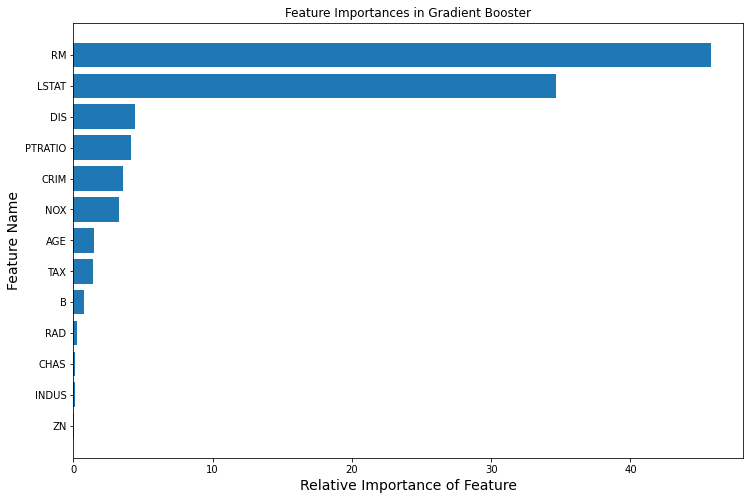

In [86]:
feature_importances = 100*model_opt.feature_importances_ / np.sum(model.feature_importances_)
feature_importances, feature_names, feature_idxs = \
    zip(*sorted(zip(feature_importances, names, range(len(names)))))

width = 0.8

idx = np.arange(len(names))
plt.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names)

plt.title("Feature Importances in Gradient Booster")
plt.xlabel('Relative Importance of Feature', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
# plt.savefig('plots/feature-importances.png', bbox_inches='tight')

In [87]:
np.sum(model.feature_importances_)

1.0

**Comments** 
- The name ”feature importances” is pretty awful. It invites misinterpretation. Don’t reason about things from the names they have been given, make sure the statistic actually answers your question.
- If your model contains both numeric and binary predictors, the importance metric is biased to assign higher values to the numeric predictors. Try not to compare feature importances across these two classes.
- Feature importance rankings can have very high variance. Make sure any important conclusions are robust to different RNG seeds and training sets.
- Make sure your model only includes trees up to the optimal point. Otherwise you’ll allocate importance to overfitting.
- Dominant features should be treated with suspicion. They can often be a sign of data leakage.

#### Optional Partial Dependence Plots
Visualizations of the effect of a single predictor, averaging out the effects of all the rest

In [101]:
model.feature_importances_

array([0.06774244, 0.00281252, 0.0129303 , 0.00403777, 0.04158093,
       0.36017313, 0.03498829, 0.13903544, 0.01539279, 0.02201765,
       0.04345531, 0.03343645, 0.22239701])

In [102]:
feature_importances, fnames, feature_idxs, np.argsort(model.feature_importances_)

((0.031945021832241745,
  0.11537114057751179,
  0.1331249682233092,
  0.27630053577156866,
  0.7830474009973123,
  1.4036202005539873,
  1.4748539517123826,
  3.236966582782521,
  3.5798515904384063,
  4.126698779202219,
  4.384195556155009,
  34.660065735657284,
  45.793958536096255),
 ['ZN',
  'INDUS',
  'CHAS',
  'RAD',
  'B',
  'TAX',
  'AGE',
  'NOX',
  'CRIM',
  'PTRATIO',
  'DIS',
  'LSTAT',
  'RM'],
 (1, 2, 3, 8, 11, 9, 6, 4, 0, 10, 7, 12, 5),
 array([ 1,  3,  2,  8,  9, 11,  6,  4, 10,  0,  7, 12,  5]))

In [110]:


%%capture
N_COLS = 3
fimportances = list(feature_importances)
fnames = list(feature_names)

pd_plots = [partial_dependence(estimator = model,
                               features = target_feature,
                               X=X_train, 
                               grid_resolution=50)
            for target_feature in feature_idxs]
pd_plots = list(zip([pdp[0][0] for pdp in pd_plots],
                    [pdp[1][0] for pdp in pd_plots]))


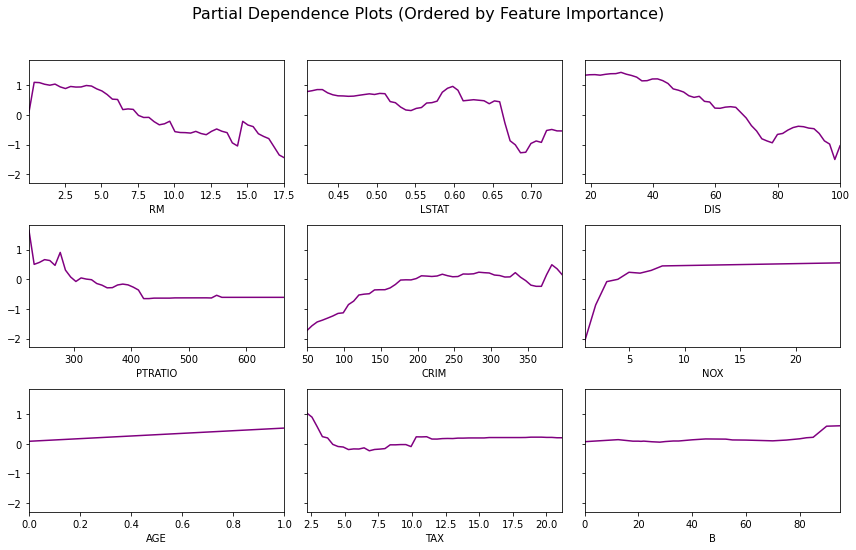

In [91]:
fig, axes = plt.subplots(nrows=3, ncols=N_COLS, sharey=True, 
                         figsize=(12.0, 8.0))
# in reversed order
for i, (y_axis, x_axis) in enumerate(pd_plots[(3*N_COLS-1)::(-1)]):
    ax = axes.flatten()[i] # axes is a 2d array
    ax.plot(x_axis, y_axis, color="purple")
    ax.set_xlim([np.min(x_axis), np.max(x_axis)])
    ax.set_xlabel(fnames[len(fnames)-1-i])
    
plt.suptitle("Partial Dependence Plots (Ordered by Feature Importance)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.savefig('plots/patial-dependence-plots.png', bbox_inches='tight')

By varying the values of two predictors, we can draw partial dependence plots in higher dimensions

Text(0.5, 0.92, 'A Partial Dependence Plot with Two Features')

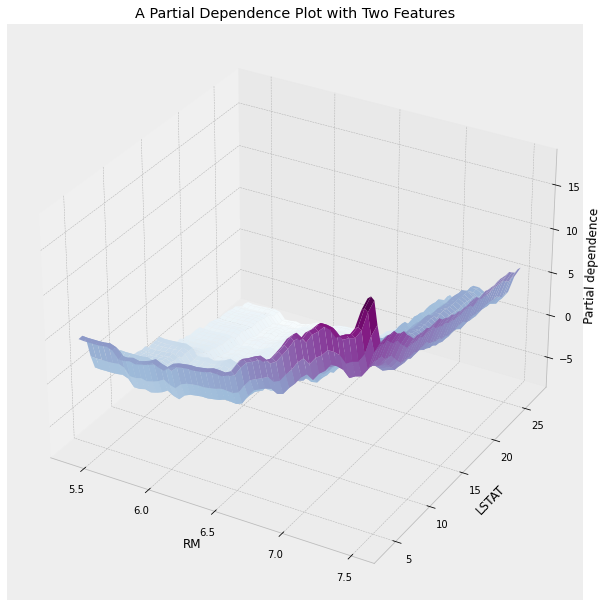

In [113]:
# Two varaibles at once
pdp, (x_axis, y_axis) = partial_dependence(estimator = model, 
                                           features= (feature_idxs[-1], feature_idxs[-2]),
                                           X=X_train,
                                           grid_resolution=50)

fig = plt.figure()
plt.style.use('bmh')

XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape)
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.view_init(elev=30, azim=300)
ax.set_xlabel(fnames[-1])
ax.set_ylabel(fnames[-2])
ax.set_zlabel('Partial dependence')
ax.set_title("A Partial Dependence Plot with Two Features")
# plt.savefig('plots/patial-dependence-plot-two-features.png', bbox_inches='tight')

# Classification
---
## Gradient Boosting Algorithms (for Classification)

The last great feature of Gradient Boosting is that it generalizes easily to other loss functions.

- **Gradient Boosted Logistic Regression:** Minimizes the binomial deviance (logistic log likelihood) loss function.
- **AdaBoost**: Minimizes a custom classification loss.

It is important to say: There are many more possibilities!

### Gradient Boosted Logistic Regression
We want to generalize our boosting algorithm to also solve classification problems.
$$y \in \{0, 1\}$$
We want to estimate $f(x) = P(y = 1 \mid x)$

In [116]:
# cubic_boundary(t_cubic)

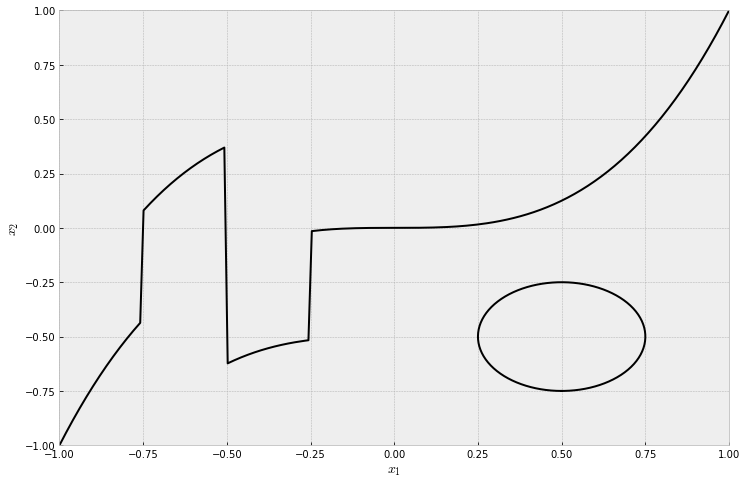

In [114]:
cubic_boundary    = lambda t: (t, t**3 + 0.5*(t > -0.75)*(t < -0.5) - 0.5*(t > -0.5)*(t < -0.25))
circular_boundary = lambda t: (0.25*np.sin(t) + 0.5, 0.25*np.cos(t) - 0.5)

t_cubic = np.linspace(-1, 1, 200)
x_cubic, y_cubic = cubic_boundary(t_cubic)
t_circle = np.linspace(-np.pi, np.pi, 200)
x_circle, y_circle = circular_boundary(t_circle)

def plot_classification_boundary():
    plt.plot(x_cubic, y_cubic, color="black", label="True Decision Boundary")
    plt.plot(x_circle, y_circle, color="black")
    plt.xlim([-1, 1]); plt.ylim([-1, 1])
    plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
    
plot_classification_boundary()    

In [121]:
X.shape

(1000, 2)

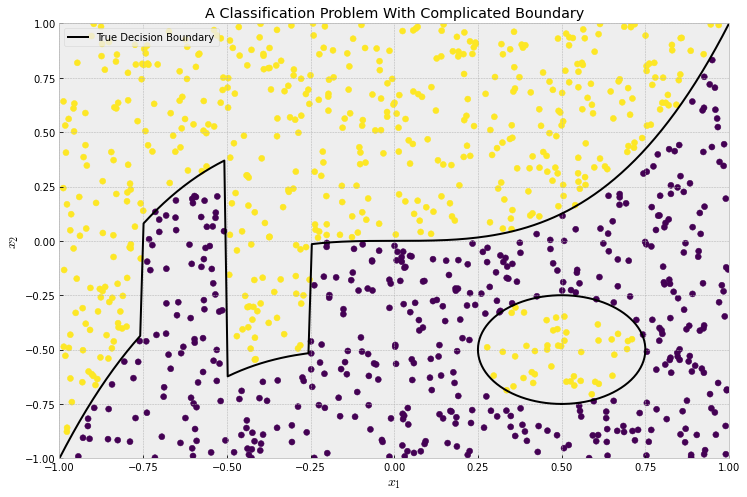

In [117]:
is_above_cubic    = lambda x, y: cubic_boundary(x)[1] < y
is_inside_circle  = lambda x, y: (x - 0.5)**2 + (y + 0.5)**2 < 0.25**2
is_positive_class = lambda x, y: np.logical_or(is_above_cubic(x, y), is_inside_circle(x, y))

N = 1000; np.random.seed(132)

xs = rand.uniform(-1, 1, N)
ys = rand.uniform(-1, 1, N)
label = is_positive_class(xs, ys)

X = np.vstack([xs, ys]).T

def plot_data():
    plt.scatter(xs, ys, c=label, marker='o')

plot_data()
plot_classification_boundary()
plt.title("A Classification Problem With Complicated Boundary")
plt.legend(loc="upper left")

# plt.savefig('plots/classification-boundary-with-data.png', bbox_inches='tight')

For example, this is a complex classification problem. 

How would you solve this with standard logistic regression?

Gradient boosted logistic regression makes short work of it.

In [122]:
def plot_contour(model):
    '''
    plot contour on a grid
    '''
    gx = np.linspace(-1, 1, 200)
    gy = np.linspace(-1, 1, 200)
    meshx, meshy = np.meshgrid(gx, gy)
    grid = np.vstack([meshx.flatten(), meshy.flatten()]).T
    p_hat = model.predict_proba(grid)[:, 1].flatten()
    plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 3), 
             alpha=0.4, cmap=plt.cm.bwr_r
#              ,label="Fit Decision Boundary"
            )

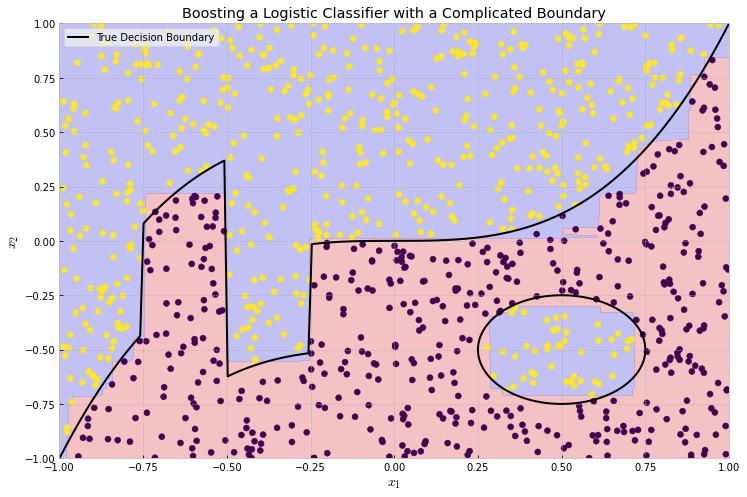

In [123]:
N_ESTIMATORS = 1000

model = GradientBoostingClassifier(learning_rate=0.01, 
                                   n_estimators=N_ESTIMATORS, 
                                   min_samples_leaf=10)
model.fit(X, label)

plot_contour(model)
plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Boosting a Logistic Classifier with a Complicated Boundary")
plt.legend(loc="upper left")

# plt.savefig('plots/classification-boundary-with-booster.png', bbox_inches='tight')

Recall our friend logistic regression.
$$\hat \beta = \arg\,\min_{\beta} \sum_i \bigl(y_i \nu(\beta, x_i) - \log(1 + \exp(\nu(\beta, x_i)))\bigr)$$

Where $\nu(\beta, x_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}$.

The quantity $\nu$ is called the linear predictor.

In logistic regression it represents the log odds of the outcome.

And once we solved for $\hat\beta$, we can make predictions, call them $p(x) = P(y = 1\mid x)$, that is, conditional probability that $y=1$ given the values of $x$. 

The function we are minimizing in logistic regression is called the *logistic loss*
$$\ell (f, y) = yf - \log(1 + \exp(f))$$

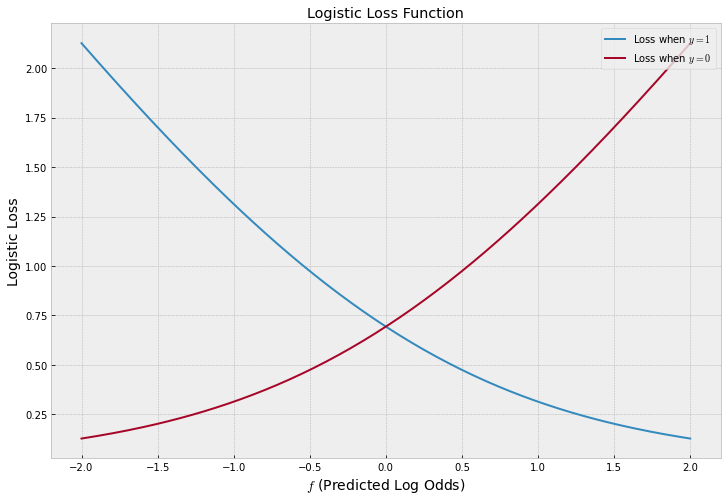

In [124]:
# Logistic loss.
x = np.linspace(-2, 2, 200)
one_branch =  - x + np.log(1 + np.exp(x))
zero_branch = np.log(1 + np.exp(x))

plt.plot(x, one_branch,  label="Loss when $y=1$")
plt.plot(x, zero_branch, label="Loss when $y=0$")

plt.legend(loc="upper right")
plt.title("Logistic Loss Function")
plt.xlabel('$f$ (Predicted Log Odds)', fontsize=14)
_ = plt.ylabel('Logistic Loss', fontsize=14)
# plt.savefig('plots/loss-function-logistic.png', bbox_inches='tight')

**(As you may remember, logistic regression can be solved with gradient descent which is to say gradually.)**

**Gradient Boosted Logistic Regression** Replace the linear predictor in logistic regression
$$\nu(\beta, x) = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p$$
With a sum of small regression trees
$$\nu(x) = T_0(x) + T_1(x) + \dots T_{\max} (x)$$

To fit a Gradient Boosted Logistic Regression, replace the least squares loss function
$$ \ell (f, y) = \frac12 (f-y)^2$$
With the logistic loss
$$\ell(f, y) = yf − \log(1 + \exp(f) )$$
And then use the same gradient boosting technique.

The gradient of the logistic loss is
\begin{align}
\nabla_f \ell (f, y) 
& = \frac{\partial}{\partial f} \bigl(yf - \log (1+\exp(f))\bigr) \\
& = y - \frac{\exp (f)}{1+\exp(f)} \\
& = y - p(f)
\end{align}
So we can interpret this method as ”boosting to the residual probabilities”.

---

Gradient boosted logistic regression is implemented in sklearn as
```
from sklearn.ensembles import GradientBoostingClassifier 
model = GradientBoostingClassifier()
#Now y must be a np.array of 0 and 1’s!
model.fit(X, y)
```

The options to GradientBoostingClassifier are the same as those to `GradientBoostingRegressor`
```
GradientBoostingClassifier ( loss=’deviance’,
                             n_estimators=100,
                             learning_rate=0.1,
                             max_depth=3,
                             subsample=1.0,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             ...)
```
And everything we said before generalizes.

To make predictions use `predict_proba`
```
model.predict_proba(X)
```

The predict method returns class labels (by comparing the probability to 0.5), making it much less useful.

### Gradient Boosted AdaBoost

By using the ‘exponential’ loss, we get the Adaboost algorithm:
```
model = GradientBoostingClassifier(loss=’exponential’)
model.fit(X, y)
```

The Adaboost algorithm uses labels $y\in\{-1, 1\}$ and minimizes the loss function
$$\ell (f,y) = \exp(-yf)$$

Text(0, 0.5, 'Exponential Loss')

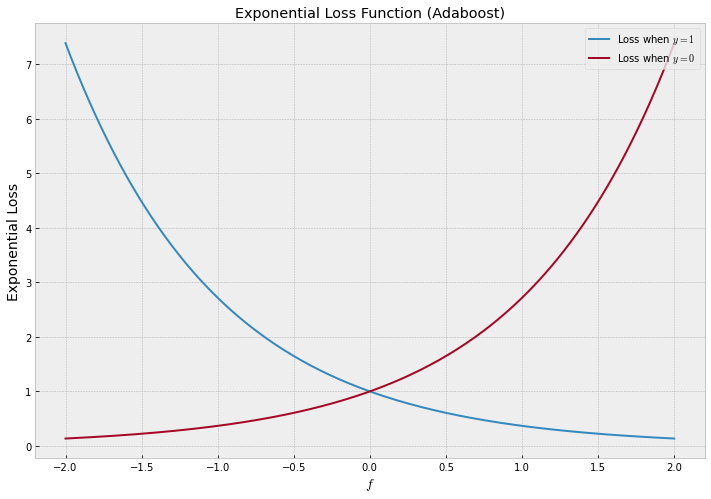

In [125]:
# Adaboost Exponential Loss
x = np.linspace(-2, 2, 200)
one_branch =  np.exp(-x)
zero_branch = np.exp(x)

plt.plot(x, one_branch, label="Loss when $y=1$")
plt.plot(x, zero_branch, label="Loss when $y=0$")

plt.legend(loc="upper right")
plt.title("Exponential Loss Function (Adaboost)")
plt.xlabel('$f$', fontsize=14)
plt.ylabel('Exponential Loss', fontsize=14)

# plt.savefig('plots/loss-function-adaboost.png', bbox_inches='tight')

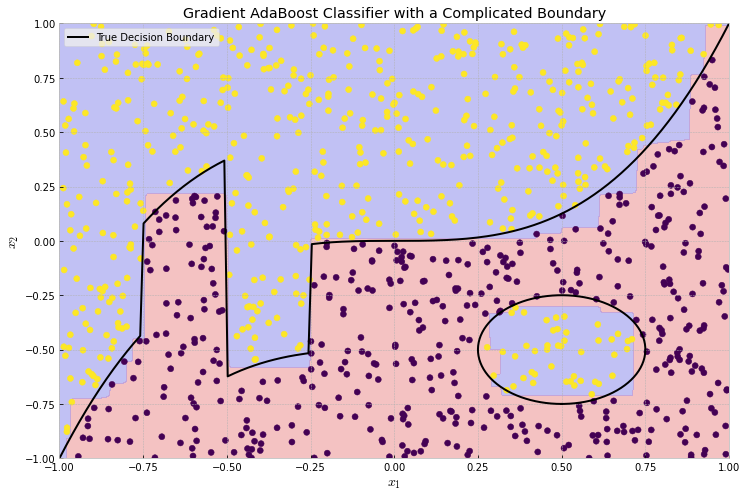

In [126]:
model = GradientBoostingClassifier(loss='exponential',
                                   learning_rate=0.01,
                                   n_estimators=N_ESTIMATORS,
                                   min_samples_leaf=10)
model.fit(X, label)

plot_contour(model)
plot_data()
plot_classification_boundary()
plt.title("Gradient AdaBoost Classifier with a Complicated Boundary")
plt.legend(loc="upper left")
# plt.savefig('plots/classification-boundary-with-ada-gradient-booster.png', bbox_inches='tight')
_ = os.system('say "your program has finished"')

The performance of Adaboost is generally comparable to that of gradient boosted logistic regression. In fact, the classification boundaries are the same

Gradient boosted logistic regression is less sensitive to outliers than Adaboost. Can you see why?

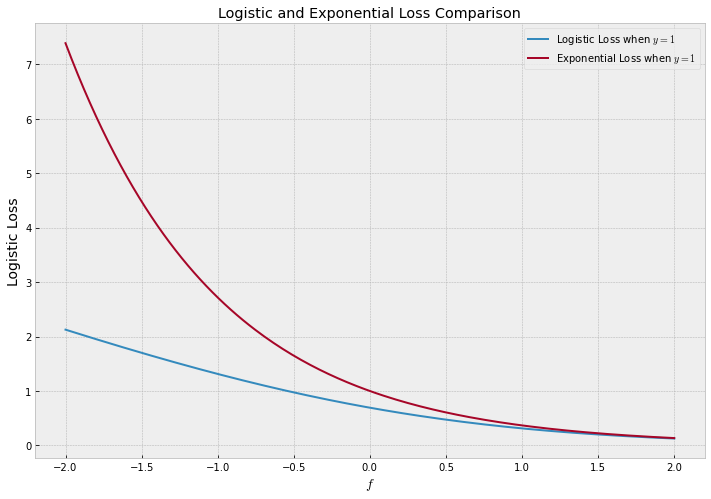

In [127]:
# Comparison
# Logistic loss.
x = np.linspace(-2, 2, 200)
logistic_branch =  - x + np.log(1 + np.exp(x))
adaboost_branch = np.exp(-x)

plt.plot(x, logistic_branch, label="Logistic Loss when $y=1$")
plt.plot(x, adaboost_branch, label="Exponential Loss when $y=1$")

plt.legend(loc="upper right")
plt.title("Logistic and Exponential Loss Comparison")
plt.xlabel('$f$', fontsize=14)
plt.ylabel('Logistic Loss', fontsize=14)

plt.savefig('loss-function-comparison.png', bbox_inches='tight')

The implementation of Adaboost as a gradient booster is a somewhat recent development.

Originally (before the invention of gradient boosting), Adaboost was accomplished by a complicated sample re-weighing scheme.

The traditional Adaboost is included in sklearn as `AdaBoostClassifier`. Traditional Adaboost always uses trees of depth 1 (often playfully called ”stumps”, so there is no max depth argument.

Traditional Adaboost is outclassed by gradient boosting, but retains historical and mathematical significance

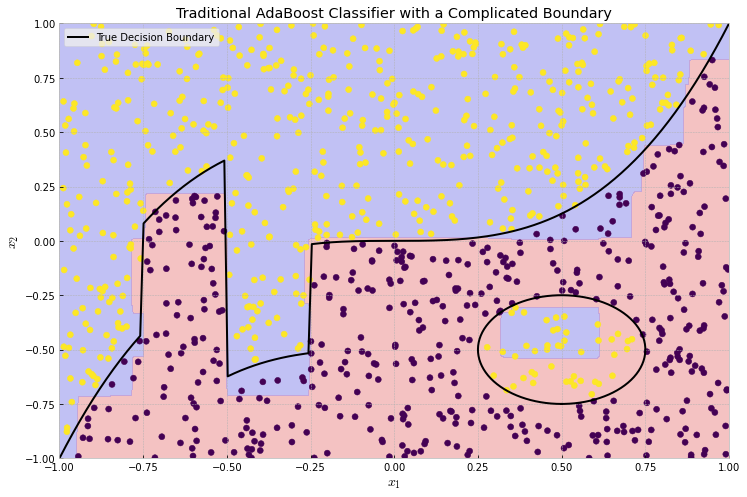

In [128]:
# longer runtime
model = AdaBoostClassifier(learning_rate=0.01, 
                           n_estimators=N_ESTIMATORS*8)
model.fit(X, label)

plot_contour(model)
plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Traditional AdaBoost Classifier with a Complicated Boundary")
plt.legend(loc="upper left")

# plt.savefig('plots/classification-boundary-with-ada-booster.png', bbox_inches='tight')

## More Mixed Classes

In [129]:
def make_mixed_classification_data(N_centers=4, N_per_center=50):
    class_centers = np.random.uniform(-1, 1, size=(2*N_centers, 2))
    cov_matrix = 0.075*np.array([[1, 0], [0, 1]])
    X = np.concatenate([
        np.random.multivariate_normal((x, y), cov_matrix, size=N_per_center) 
        for x, y in class_centers]).squeeze()
    class_labels = np.concatenate([
        np.repeat(0, N_centers*N_per_center), np.repeat(1, N_centers*N_per_center)
    ]).squeeze()
    return class_centers, X, class_labels

In [130]:
np.random.seed(333)
class_centers, X, class_labels = make_mixed_classification_data(5)

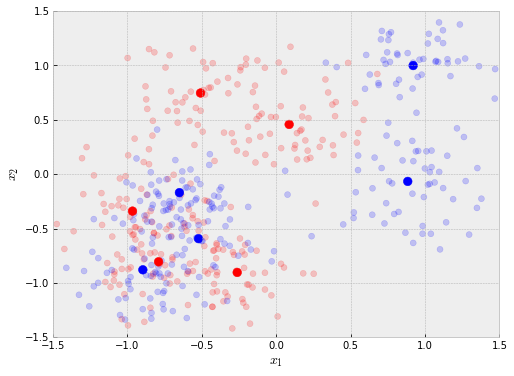

In [131]:
## plot mixed data
colors = np.array(['red', 'blue'])

def plot_mixed_data(ax, class_centers, X, class_labels):
    ax.scatter(X[:, 0], X[:, 1], c=colors[class_labels], alpha=0.2)
    center_colors = np.concatenate([
        np.repeat(0, class_centers.shape[0] // 2), 
        np.repeat(1, class_centers.shape[0] // 2)
    ])    
    ax.scatter(class_centers[:, 0], class_centers[:, 1], 
                c=colors[center_colors], 
                marker='o', s=75)
    ax.set_xlabel('$x_1$', fontsize=14) 
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
fig, ax = plt.subplots(figsize=(8, 6))
plot_mixed_data(ax, class_centers, X, class_labels)

In [132]:
model = GradientBoostingClassifier(learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5,
                                   max_depth=2,
                                   subsample=0.5)
model.fit(X, class_labels)

GradientBoostingClassifier(learning_rate=0.005, max_depth=2, min_samples_leaf=5,
                           n_estimators=500, subsample=0.5)

### How the Predictions Evolve

In [135]:
def plot_predictions(ax, model, n_tree=None):
    gx = np.linspace(-1.5, 1.5, 500)
    gy = np.linspace(-1.5, 1.5, 500)
    meshx, meshy = np.meshgrid(gx, gy)
    grid = np.vstack([meshx.flatten(), meshy.flatten()]).T
    
    if n_trees:
        p_hats = model.staged_predict_proba(grid)
        p_hat = next(islice(p_hats, n_tree, n_tree + 1))[:, 1]
    else:
        p_hat = model.predict_proba(grid)[:, 1].flatten()
    
    ax.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
                 levels=np.linspace(0, 1, 35), 
                 alpha=0.4, cmap=plt.cm.bwr_r)

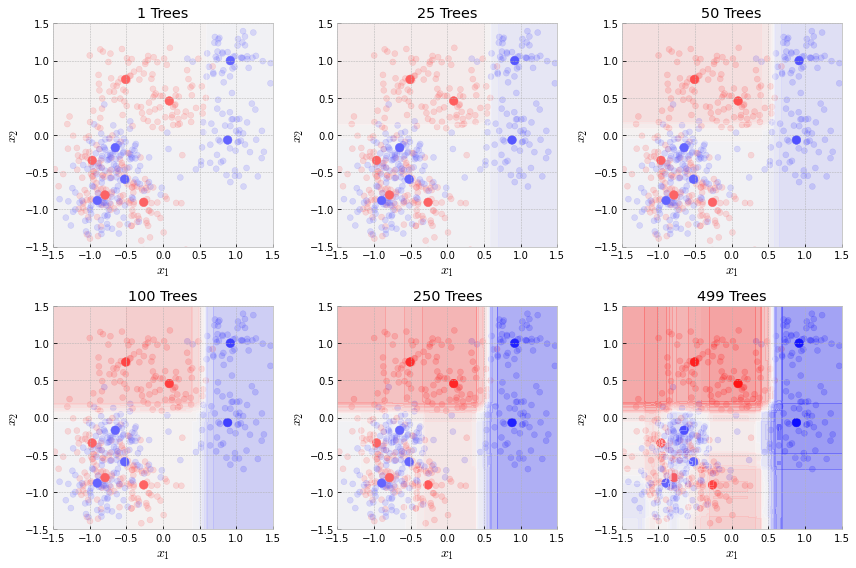

In [134]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

n_trees = [1, 25, 50, 100, 250, 499]
for ax, n_tree in zip(axs.flatten(), n_trees):
    plot_mixed_data(ax, class_centers, X, class_labels)
    plot_predictions(ax, model, n_tree=n_tree)
    ax.set_title("{} Trees".format(n_tree))
    
fig.tight_layout()

## How the Gradient Evolves Over Time


In [136]:
def plot_logistic_gradient(ax, model, X, y, n_tree=None):        
    if n_trees:
        p_hats = model.staged_predict_proba(X)
        p_hat = next(islice(p_hats, n_tree, n_tree + 1))[:, 1]
    else:
        p_hat = model.predict_proba(X)[:, 1].flatten()
    
    gradient = p_hat - y
    ax.scatter(X[:, 0], X[:, 1], 
               c=gradient, vmin=-1, vmax=1,
               cmap=plt.cm.bwr)

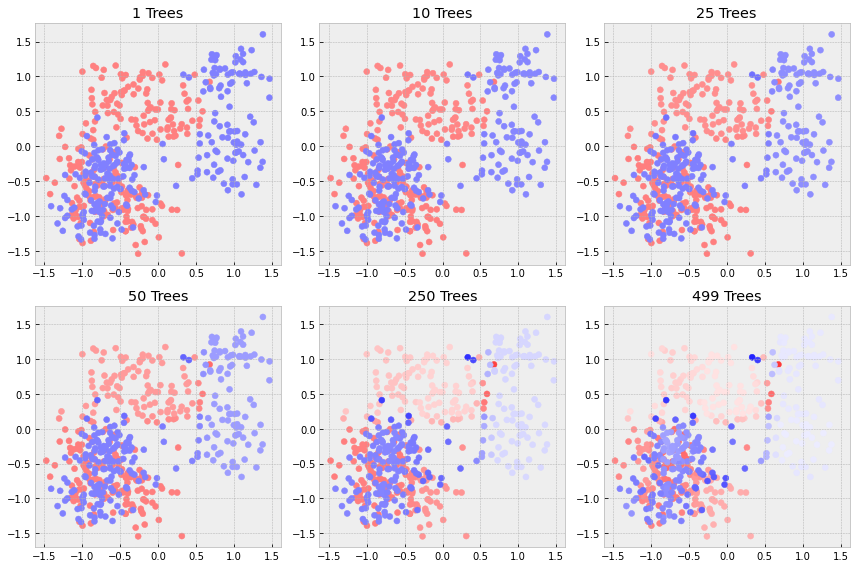

In [137]:
## plot gradient evolution
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

n_trees = [1, 10, 25, 50, 250, 499]
for ax, n_tree in zip(axs.flatten(), n_trees):
    plot_logistic_gradient(ax, model, X, class_labels, n_tree=n_tree)
    ax.set_title("{} Trees".format(n_tree))
    
fig.tight_layout()

### Putting Model Predictions and Gradients side by side

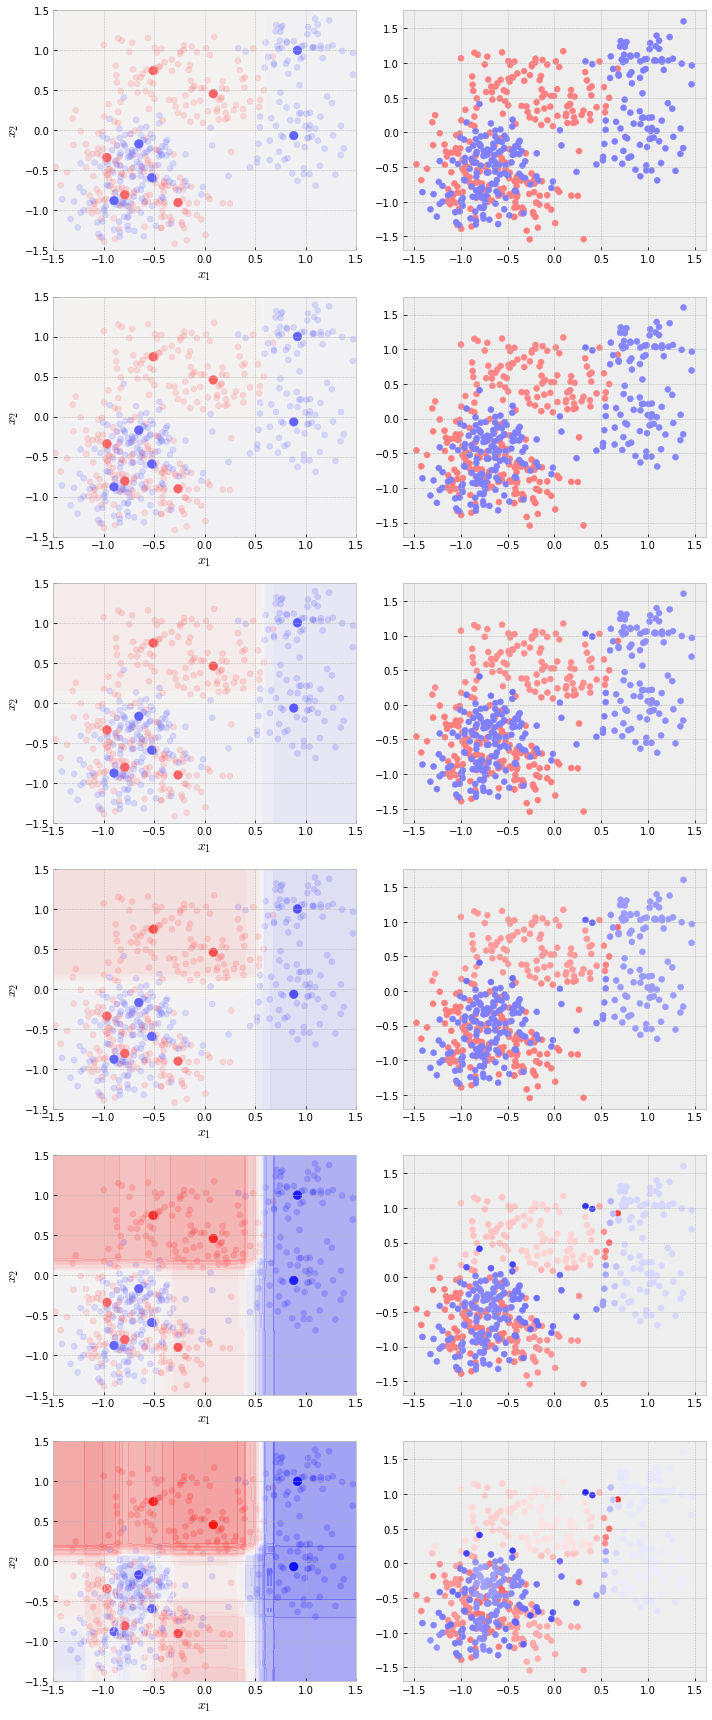

In [138]:
fig, axs = plt.subplots(6, 2, figsize=(10, 24))

n_trees = [1, 10, 25, 50, 250, 499]
for ax_tuple, n_tree in zip(axs, n_trees):
    plot_mixed_data(ax_tuple[0], class_centers, X, class_labels)
    plot_predictions(ax_tuple[0], model, n_tree=n_tree)
    plot_logistic_gradient(ax_tuple[1], model, X, class_labels, n_tree=n_tree)
    ax.set_title("{} Trees".format(n_tree))
    
fig.tight_layout()

## A Final Comparison of Classification Algorithms

In [139]:
## reset data
def plot_contour2(model):
    '''
    plot contour on a grid
    '''
    gx = np.linspace(-1.5, 1.5, 500)
    gy = np.linspace(-1.5, 1.5, 500)
    meshx, meshy = np.meshgrid(gx, gy)
    grid = np.vstack([meshx.flatten(), meshy.flatten()]).T
    p_hat = model.predict_proba(grid)[:, 0].flatten()
    plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r)
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
## reset function
def plot_mixed_data():
    plt.scatter(Xx, Xy, c=colors[label], alpha=0.2)
    plt.scatter(class_centers_xs, class_centers_ys, marker='o', s=75, 
                color=colors[[0, 0, 0, 0, 1, 1, 1, 1]])
    
N = 1000
np.random.seed(seed=210)

class_centers_xs = rand.uniform(-1, 1, 8)
class_centers_ys = rand.uniform(-1, 1, 8)

class_idxs = rand.randint(0, 8, size=N)
label = class_idxs // 4

X = np.array([rand.multivariate_normal((x, y), 0.075*np.array([[1, 0], [0, 1]]), size=1) 
              for x, y in zip([class_centers_xs[idx] for idx in class_idxs], 
                              [class_centers_ys[idx] for idx in class_idxs])]).squeeze()
Xx = X[:, 0]
Xy = X[:, 1]

colors = np.array(['blue', 'red'])

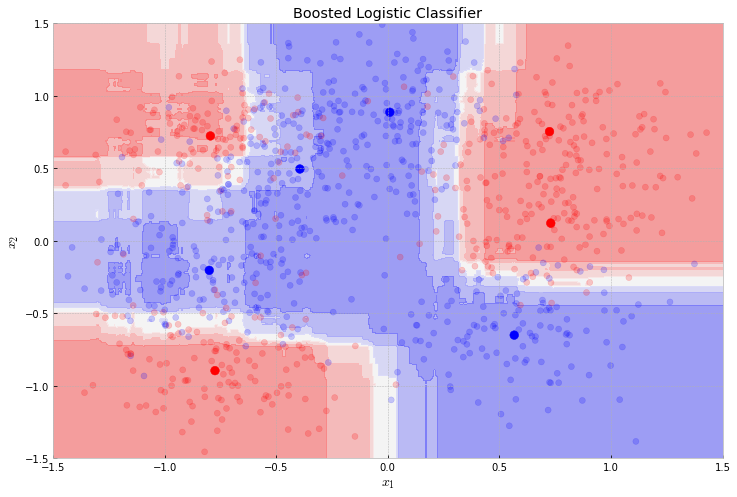

In [140]:
model = GradientBoostingClassifier(learning_rate=0.01,
                                   n_estimators=500,
                                   min_samples_leaf=5,
                                   subsample=0.5)
model.fit(X, label)
plot_contour2(model)
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
_ = plt.title("Boosted Logistic Classifier")
# plt.savefig('plots/classification-mixed-logistic-boosting.png', bbox_inches='tight')

In [ ]:
model = GradientBoostingClassifier(loss='exponential',
                                   learning_rate=0.01,
                                   n_estimators=500,
                                   min_samples_leaf=5,
                                   subsample=0.5)
model.fit(X, label)

plot_contour2(model)
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
_ = plt.title("Gradient Boosted AdaBoost Classifier")
# plt.savefig('plots/classification-mixed-ada-gradient-boosting.png', bbox_inches='tight')

In [ ]:
model = AdaBoostClassifier(learning_rate=0.01,
                           n_estimators=4*500)
model.fit(X, label)

plot_contour2(model)
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Traditional AdaBoost Classifier")
# plt.savefig('plots/classification-mixed-ada-traditional-boosting.png', bbox_inches='tight')
_ = os.system('say "your program has finished"')

In [ ]:
model = SVC(C=0.5, probability=True, gamma = "scale") # Support Vector Classification

model.fit(X, label)

plot_contour2(model)
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
_ = plt.title("Support Vector Machine with RBF Kernel")
# plt.savefig('plots/classification-mixed-svm.png', bbox_inches='tight')

In [ ]:
model = RandomForestClassifier(n_estimators=5000, n_jobs=6, max_features=2)

model.fit(X, label)

plot_contour2(model)
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Random Forest Classifier")
# plt.savefig('plots/classification-mixed-random-forest.png', bbox_inches='tight')
_ = os.system('say "your program has finished"')

## Final words about boosting
Gradient Boosting is the best off-the-shelf learning algorithm available today.

It effortlessly produces accurate models.

Nonetheless, it has drawbacks.
- Boosting creates very complex models. It can be difficult to extract intuitive, conceptual, or inferential information from them.
- Boosting is difficult to explain (maybe you just learned this through experience). It can be hard to convince business leader to accept such a black box model.
- Boosted models can be difficult to implement in production environments due to their complexity.
- The sequential nature of the standard boosting algorithm makes it very difficult to parallelize (compared to, for example, random forest). Recently, there has been great progress (xgboost and to a lesser degree of accuracy LightGBM).
